🎯 COMPARAISON DE 6 MODÈLES DE CLUSTERING POUR CVs
📂 Chargement des données...
✅ Données chargées : 54 CVs, 21 colonnes

🔧 Préparation des features...
✅ Features préparées : 21 features pour 54 CVs

📋 Features utilisées :
    1. Mots
    2. Compétences
    3. Ratio_Comp_Mots
    4. Densite_Competences
    5. A_Email
    6. A_Telephone
    7. A_Permis
    8. Nb_Langues
    9. Nb_Comp_Tech
   10. Diplome_Encoded
   11. Longueur_Encoded
   12. Dept_94
   13. Dept_92
   14. Dept_93
   15. Dept_57
   16. Dept_Inconnu
   17. Dept_69
   18. Dept_31
   19. Dept_95
   20. Dept_45
   21. Dept_52

🔧 Normalisation des données...
✅ Données normalisées

🔍 Recherche du nombre optimal de clusters...
   Scores Silhouette par k: {2: '0.184', 3: '0.227', 4: '0.223', 5: '0.239', 6: '0.251', 7: '0.255', 8: '0.268'}
🎯 Nombre optimal de clusters : 8

🤖 Entraînement de 6 modèles de clustering (k=8)...

1️⃣ K-Means...
2️⃣ K-Means++ (init optimisée)...
3️⃣ Agglomerative Clustering...
4️⃣ Gaussian Mixture Model..

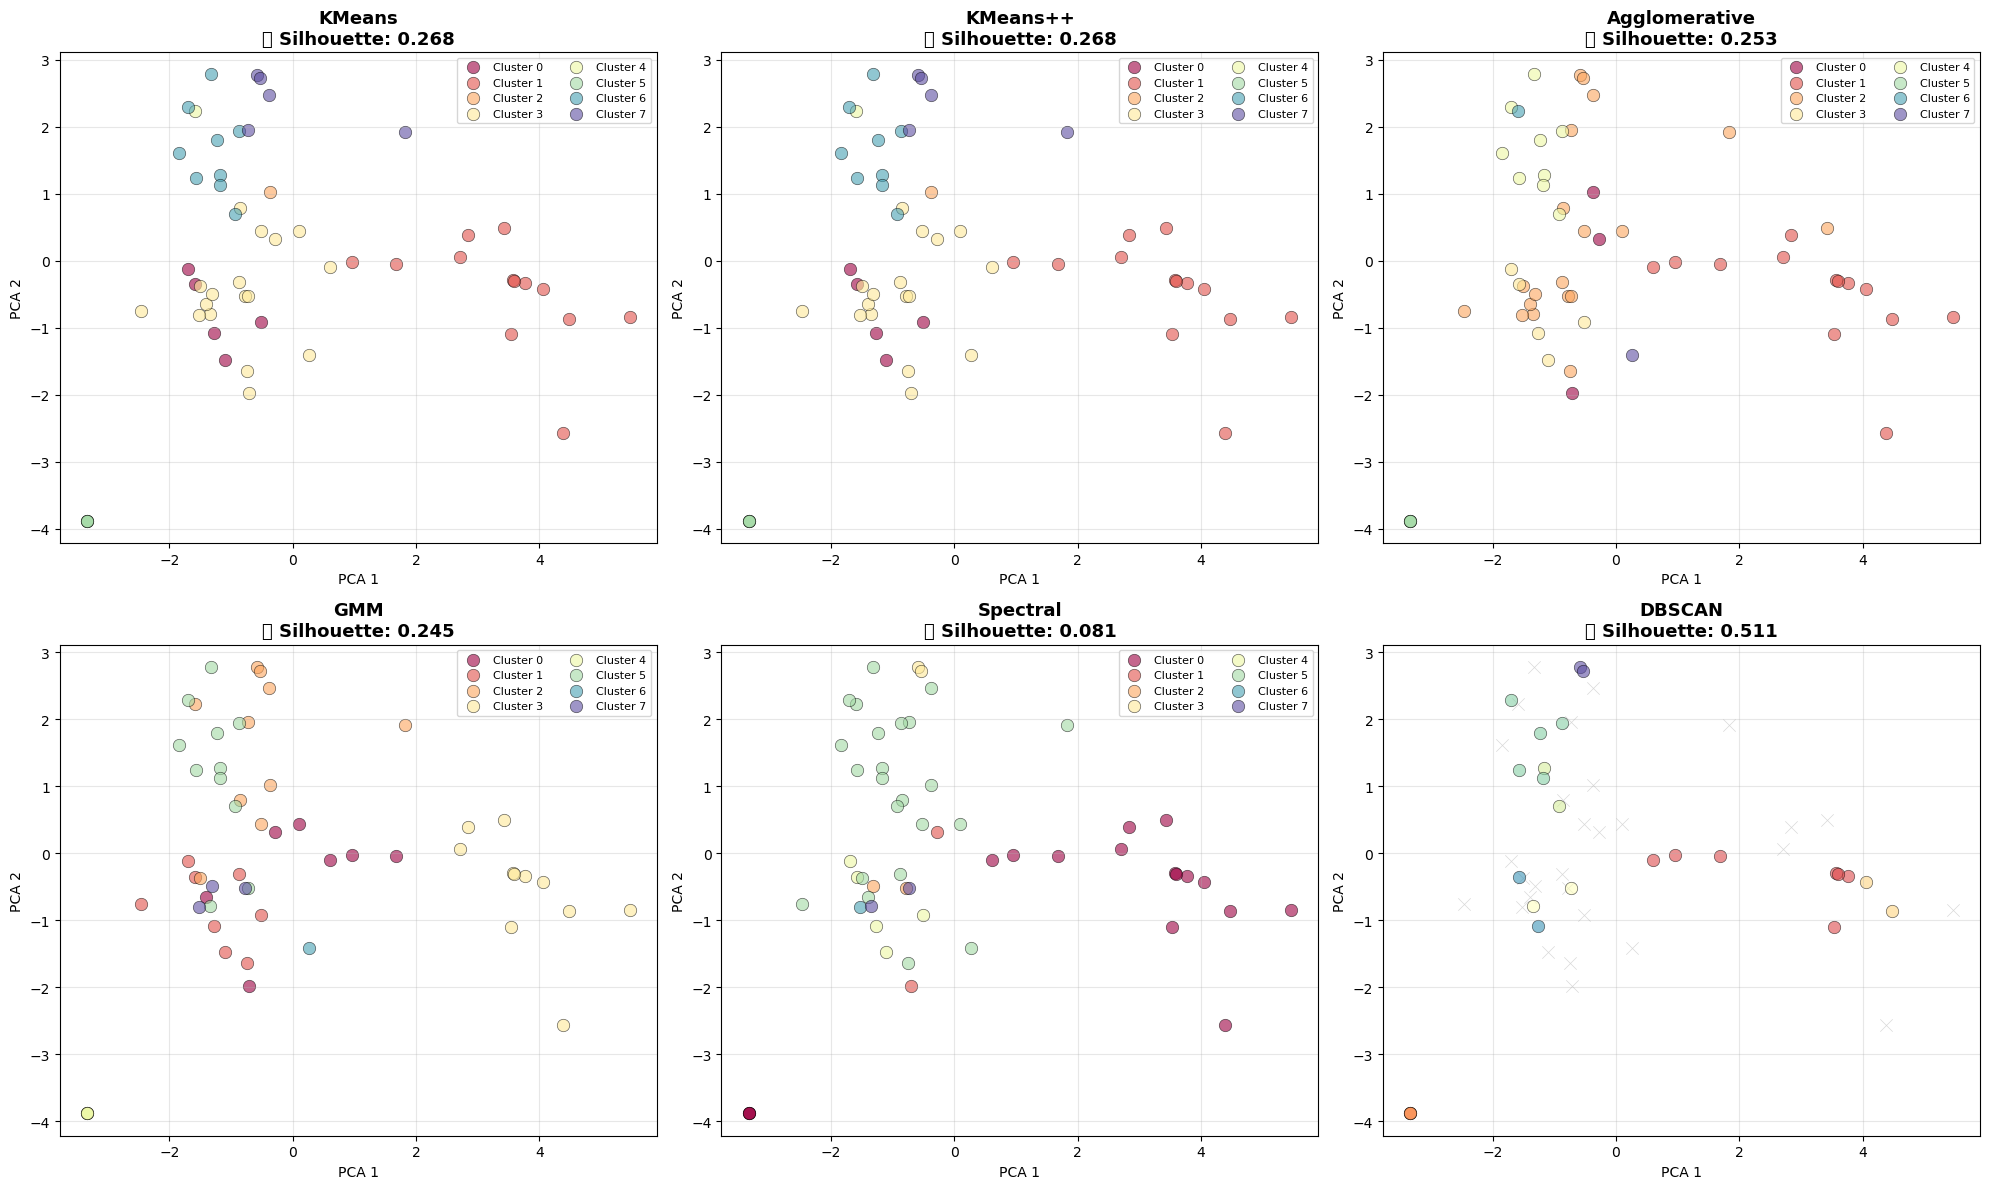


🎨 Visualisation avec TSNE...
✅ Visualisation sauvegardée: models\clustering_comparison_tsne.png


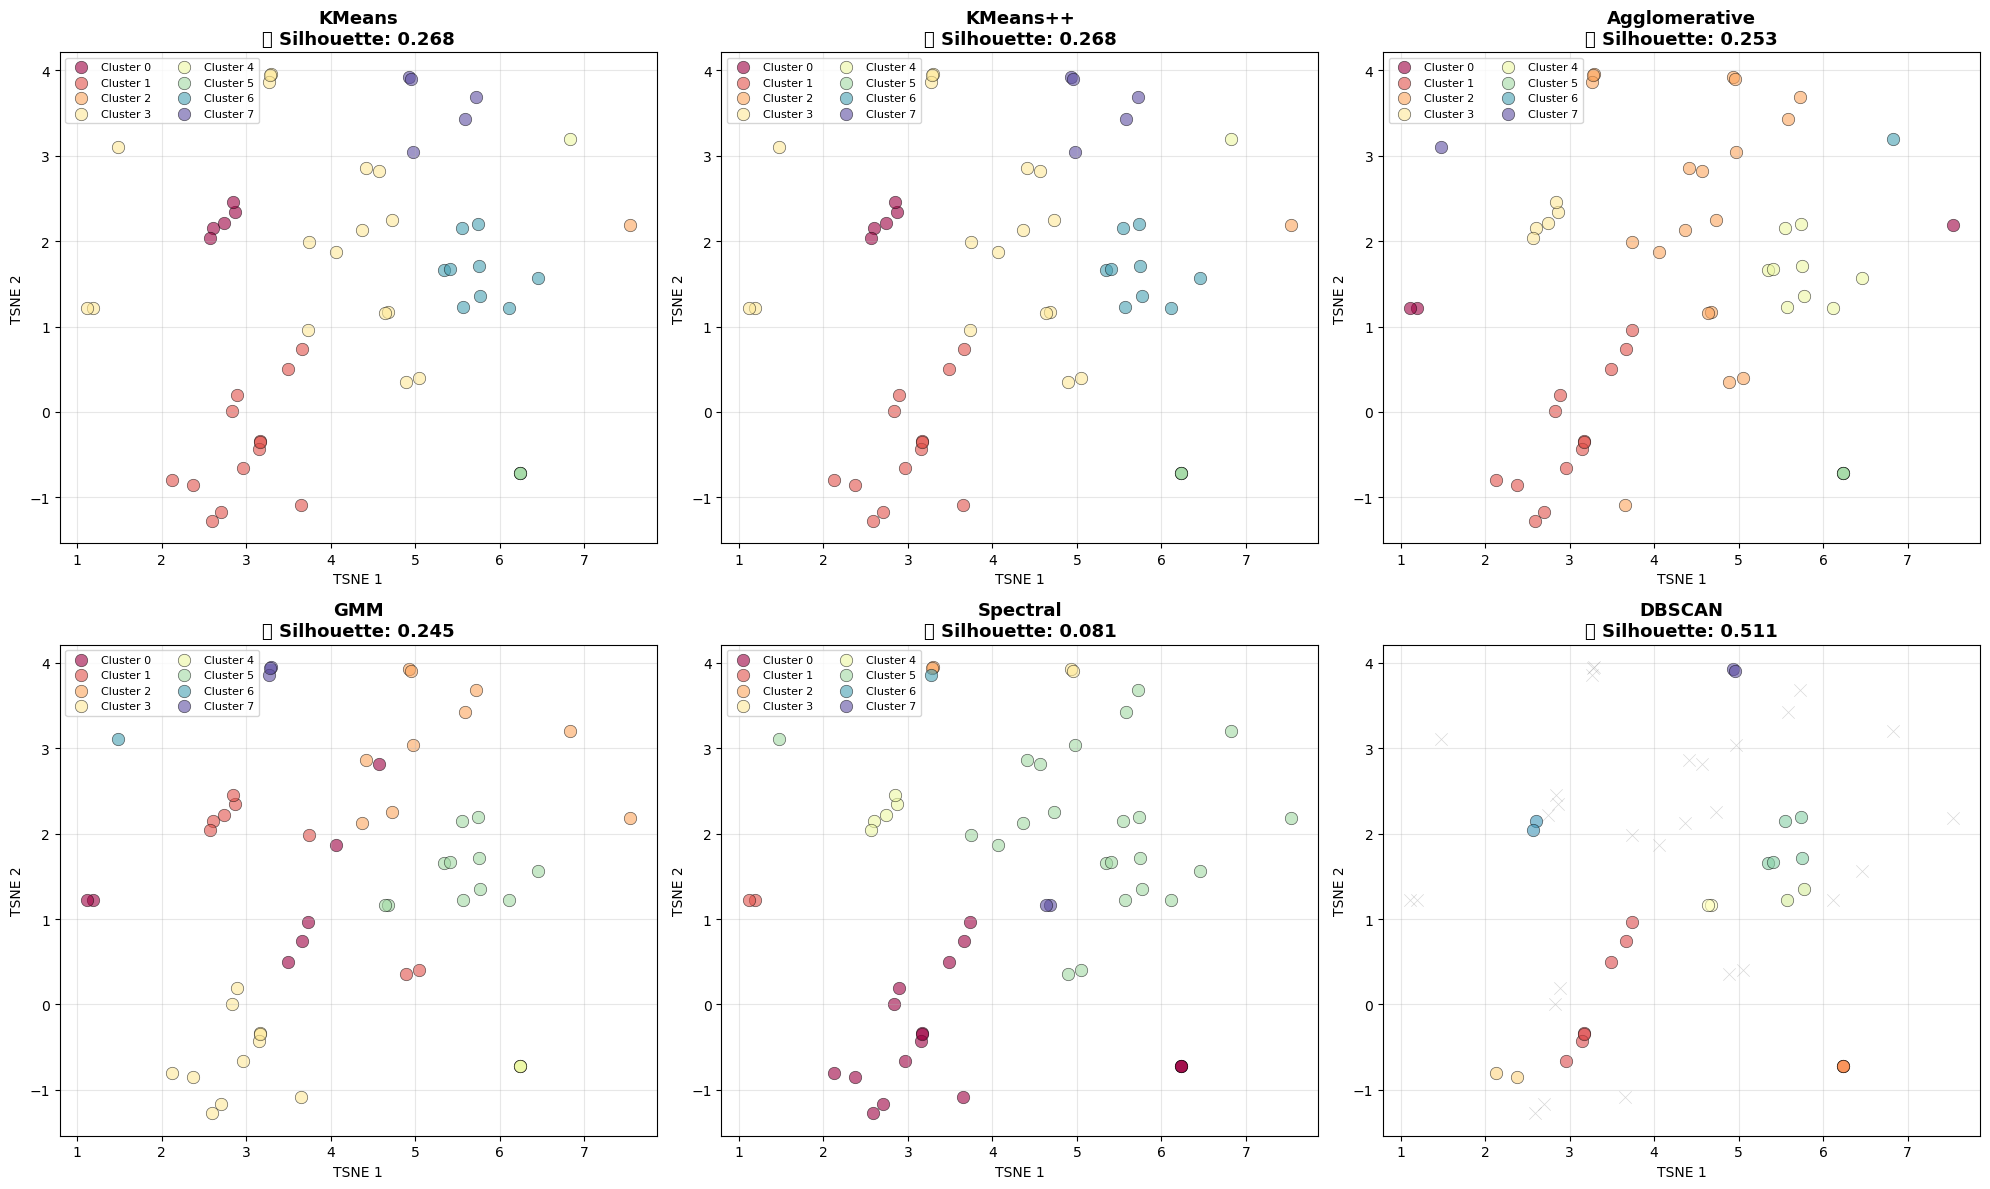


🏆 MEILLEUR MODÈLE:

🥇 DBSCAN
   • Silhouette Score: 0.5110
   • Davies-Bouldin: 0.6320
   • Calinski-Harabasz: 21.1599
   • Nombre de clusters: 8

🔍 ANALYSE DES PROFILS - DBSCAN

⚠️  BRUIT (29 CVs ignorés)

📊 CLUSTER 0 (7 CVs)
--------------------------------------------------------------------------------
   📄 Exemples: CV12.pdf, CV17.pdf, CV18.pdf
   📈 Moyennes: Mots: 373 | Compétences: 18.7 | Langues: 2.0 | Tech: 2.4
   🎓 Diplômes: Bachelor (5), Baccalauréat (1)
   📍 Départements: 94 (7)
   ✅ Présence: Email: 100% | Permis: 14%

📊 CLUSTER 1 (3 CVs)
--------------------------------------------------------------------------------
   📄 Exemples: CV15.pdf, CV23.pdf, CV3.pdf
   📈 Moyennes: Mots: nan | Compétences: nan | Langues: 1.0 | Tech: 0.0
   🎓 Diplômes: 
   📍 Départements: Inconnu (3)
   ✅ Présence: Email: 100% | Permis: 100%

📊 CLUSTER 2 (2 CVs)
--------------------------------------------------------------------------------
   📄 Exemples: CV24.pdf, CV16.pdf
   📈 Moyennes: Mots: 

In [6]:
"""
Modèles de Clustering Non Supervisés pour Classification de CV
Teste 6 algorithmes différents et compare leurs performances
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

class CVClusteringComparison:
    def __init__(self, data_path='data/processed/dataset_cv_preprocessed.csv', n_clusters=None):
        """
        Initialisation avec le chemin des données
        n_clusters: nombre de secteurs d'activité attendus (None = auto-détection)
        """
        self.data_path = data_path
        self.n_clusters = n_clusters
        self.X = None
        self.y_true = None
        self.df = None
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        
    def load_data(self):
        """Charge les données prétraitées depuis le CSV"""
        print("📂 Chargement des données...")
        
        try:
            self.df = pd.read_csv(self.data_path)
            print(f"✅ Données chargées : {self.df.shape[0]} CVs, {self.df.shape[1]} colonnes")
            return True
            
        except FileNotFoundError:
            print(f"❌ Fichier introuvable : {self.data_path}")
            print("💡 Assure-toi que le preprocessing est terminé !")
            return False
    
    def prepare_features(self):
        """Sélectionne et prépare les features pour le clustering"""
        print("\n🔧 Préparation des features...")
        
        # Features numériques directes
        numeric_features = [
            'Mots', 'Compétences', 'Ratio_Comp_Mots', 
            'Densite_Competences', 'A_Email', 'A_Telephone', 
            'A_Permis', 'Nb_Langues', 'Nb_Comp_Tech'
        ]
        
        # Créer le DataFrame de features
        X = pd.DataFrame()
        
        for feat in numeric_features:
            if feat in self.df.columns:
                X[feat] = pd.to_numeric(self.df[feat], errors='coerce').fillna(0)
        
        # Encoder les features catégorielles
        if 'Diplôme' in self.df.columns:
            le_diplome = LabelEncoder()
            X['Diplome_Encoded'] = le_diplome.fit_transform(
                self.df['Diplôme'].fillna('Inconnu').astype(str)
            )
        
        if 'Categorie_Longueur' in self.df.columns:
            le_longueur = LabelEncoder()
            X['Longueur_Encoded'] = le_longueur.fit_transform(
                self.df['Categorie_Longueur'].fillna('Moyen').astype(str)
            )
        
        if 'Departement' in self.df.columns:
            # One-hot pour les top départements
            top_depts = self.df['Departement'].value_counts().head(10).index
            for dept in top_depts:
                X[f'Dept_{dept}'] = (self.df['Departement'] == dept).astype(int)
        
        self.X = X
        
        print(f"✅ Features préparées : {self.X.shape[1]} features pour {self.X.shape[0]} CVs")
        print(f"\n📋 Features utilisées :")
        for i, col in enumerate(self.X.columns, 1):
            print(f"   {i:2d}. {col}")
        
    def prepare_data(self):
        """Normalise les données et détermine k optimal si nécessaire"""
        print("\n🔧 Normalisation des données...")
        self.X_scaled = self.scaler.fit_transform(self.X)
        print("✅ Données normalisées")
        
        # Déterminer k optimal APRÈS normalisation
        if self.n_clusters is None:
            self.n_clusters = self._find_optimal_k()
            print(f"🎯 Nombre optimal de clusters : {self.n_clusters}")
    
    def _find_optimal_k(self):
        """Trouve le nombre optimal de clusters avec la méthode du coude"""
        print("\n🔍 Recherche du nombre optimal de clusters...")
        
        # Normaliser temporairement
        X_temp = self.scaler.fit_transform(self.X)
        
        # Tester k de 2 à 8
        inertias = []
        silhouettes = []
        k_range = range(2, min(9, len(self.X)))
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_temp)
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(X_temp, labels))
        
        # Choisir k avec meilleur silhouette
        best_k = k_range[np.argmax(silhouettes)]
        print(f"   Scores Silhouette par k: {dict(zip(k_range, [f'{s:.3f}' for s in silhouettes]))}")
        
        return best_k
        
    def train_all_models(self):
        """Entraîne les 6 modèles de clustering"""
        print(f"\n🤖 Entraînement de 6 modèles de clustering (k={self.n_clusters})...\n")
        
        # 1. K-Means (Le classique)
        print("1️⃣ K-Means...")
        self.models['KMeans'] = KMeans(
            n_clusters=self.n_clusters, 
            random_state=42, 
            n_init=10
        )
        self.models['KMeans'].fit(self.X_scaled)
        
        # 2. K-Means++ (Initialisation améliorée)
        print("2️⃣ K-Means++ (init optimisée)...")
        self.models['KMeans++'] = KMeans(
            n_clusters=self.n_clusters, 
            init='k-means++',
            random_state=42, 
            n_init=20
        )
        self.models['KMeans++'].fit(self.X_scaled)
        
        # 3. Agglomerative Clustering (Hiérarchique)
        print("3️⃣ Agglomerative Clustering...")
        self.models['Agglomerative'] = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage='ward'
        )
        self.models['Agglomerative'].fit(self.X_scaled)
        
        # 4. Gaussian Mixture Model (Probabiliste)
        print("4️⃣ Gaussian Mixture Model...")
        self.models['GMM'] = GaussianMixture(
            n_components=self.n_clusters,
            random_state=42,
            covariance_type='full'
        )
        self.models['GMM'].fit(self.X_scaled)
        
        # 5. Spectral Clustering
        print("5️⃣ Spectral Clustering...")
        self.models['Spectral'] = SpectralClustering(
            n_clusters=self.n_clusters,
            random_state=42,
            affinity='rbf'
        )
        self.models['Spectral'].fit(self.X_scaled)
        
        # 6. DBSCAN (Density-based)
        print("6️⃣ DBSCAN...")
        self.models['DBSCAN'] = DBSCAN(
            eps=2.5,
            min_samples=2
        )
        self.models['DBSCAN'].fit(self.X_scaled)
        
        print("\n✅ Tous les modèles entraînés !")
        
    def get_labels(self, model_name):
        """Récupère les labels pour un modèle donné"""
        model = self.models[model_name]
        
        if hasattr(model, 'labels_'):
            return model.labels_
        elif hasattr(model, 'predict'):
            return model.predict(self.X_scaled)
        else:
            return None
    
    def evaluate_models(self):
        """Évalue tous les modèles avec plusieurs métriques"""
        print("\n📊 Évaluation des modèles...\n")
        
        metrics_data = []
        
        for name, model in self.models.items():
            labels = self.get_labels(name)
            
            if labels is None:
                continue
            
            # Nombre de clusters trouvés
            n_clusters_found = len(np.unique(labels[labels != -1]))
            n_noise = np.sum(labels == -1)
            
            # Métriques uniquement si au moins 2 clusters
            if n_clusters_found >= 2:
                try:
                    # Exclure le bruit pour les métriques
                    mask = labels != -1
                    silhouette = silhouette_score(self.X_scaled[mask], labels[mask])
                    davies_bouldin = davies_bouldin_score(self.X_scaled[mask], labels[mask])
                    calinski = calinski_harabasz_score(self.X_scaled[mask], labels[mask])
                except:
                    silhouette = davies_bouldin = calinski = np.nan
            else:
                silhouette = davies_bouldin = calinski = np.nan
            
            metrics_data.append({
                'Modèle': name,
                'Silhouette': silhouette,
                'Davies-Bouldin': davies_bouldin,
                'Calinski-Harabasz': calinski,
                'N_Clusters': n_clusters_found,
                'Bruit': n_noise
            })
            
            self.results[name] = {
                'labels': labels,
                'n_clusters': n_clusters_found,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski': calinski
            }
        
        # Créer le DataFrame
        df_results = pd.DataFrame(metrics_data)
        
        # Afficher le tableau formaté
        print("\n" + "="*90)
        print(" "*25 + "📊 RÉSULTATS DES MODÈLES DE CLUSTERING")
        print("="*90)
        
        # Créer un tableau formaté avec pandas
        display_df = df_results.copy()
        display_df['Silhouette'] = display_df['Silhouette'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
        display_df['Davies-Bouldin'] = display_df['Davies-Bouldin'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
        display_df['Calinski-Harabasz'] = display_df['Calinski-Harabasz'].apply(lambda x: f"{x:.2f}" if not np.isnan(x) else "N/A")
        
        print(display_df.to_string(index=False))
        print("="*90)
        
        # Légende
        print("\n📌 LÉGENDE DES MÉTRIQUES:")
        print("   • Silhouette        : Cohésion des clusters (+ proche de 1 = meilleur)")
        print("   • Davies-Bouldin    : Séparation des clusters (+ proche de 0 = meilleur)")
        print("   • Calinski-Harabasz : Variance inter/intra clusters (+ grand = meilleur)")
        
        # Identifier le meilleur
        valid_df = df_results[df_results['Silhouette'].notna()].copy()
        if len(valid_df) > 0:
            best_idx = valid_df['Silhouette'].idxmax()
            best_model = valid_df.loc[best_idx, 'Modèle']
            best_score = valid_df.loc[best_idx, 'Silhouette']
            
            print(f"\n🏆 MEILLEUR MODÈLE (Silhouette): {best_model} (Score: {best_score:.4f})")
        
        return df_results
    
    def visualize_clusters(self, method='PCA'):
        """Visualise tous les clusterings en 2D"""
        print(f"\n🎨 Visualisation avec {method}...")
        
        # Réduction de dimensionnalité
        if method == 'PCA':
            reducer = PCA(n_components=2, random_state=42)
            X_2d = reducer.fit_transform(self.X_scaled)
            explained_var = reducer.explained_variance_ratio_
            print(f"   Variance expliquée : PC1={explained_var[0]:.1%}, PC2={explained_var[1]:.1%}")
        else:  # t-SNE
            reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.X_scaled)-1))
            X_2d = reducer.fit_transform(self.X_scaled)
        
        # Créer une figure avec subplots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.ravel()
        
        for idx, (name, model) in enumerate(self.models.items()):
            labels = self.get_labels(name)
            
            if labels is None:
                continue
            
            ax = axes[idx]
            
            # Gérer le bruit (label -1) pour DBSCAN
            unique_labels = np.unique(labels)
            colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
            
            for label, color in zip(unique_labels, colors):
                if label == -1:
                    color = 'gray'
                    marker = 'x'
                    label_name = 'Bruit'
                    alpha = 0.3
                else:
                    marker = 'o'
                    label_name = f'Cluster {label}'
                    alpha = 0.6
                
                mask = labels == label
                ax.scatter(
                    X_2d[mask, 0], 
                    X_2d[mask, 1],
                    c=[color],
                    marker=marker,
                    s=80,
                    alpha=alpha,
                    edgecolors='black',
                    linewidth=0.5,
                    label=label_name
                )
            
            # Titre avec métrique
            silhouette = self.results[name].get('silhouette', np.nan)
            if not np.isnan(silhouette):
                title = f"{name}\n✅ Silhouette: {silhouette:.3f}"
            else:
                title = f"{name}\n⚠️ Score non disponible"
            
            ax.set_title(title, fontsize=13, fontweight='bold')
            ax.set_xlabel(f'{method} 1', fontsize=10)
            ax.set_ylabel(f'{method} 2', fontsize=10)
            
            # Légende plus compacte
            if len(unique_labels) <= 8:
                ax.legend(loc='best', fontsize=8, ncol=2)
            
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Sauvegarder
        output_dir = Path('models')
        output_dir.mkdir(exist_ok=True)
        output_path = output_dir / f'clustering_comparison_{method.lower()}.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualisation sauvegardée: {output_path}")
        
        plt.show()
    
    def analyze_cluster_profiles(self, model_name):
        """Analyse détaillée des profils de chaque cluster"""
        print(f"\n🔍 ANALYSE DES PROFILS - {model_name}")
        print("=" * 80)
        
        labels = self.get_labels(model_name)
        
        for cluster_id in sorted(np.unique(labels)):
            if cluster_id == -1:
                print(f"\n⚠️  BRUIT ({(labels == -1).sum()} CVs ignorés)")
                continue
                
            mask = labels == cluster_id
            cluster_df = self.df[mask]
            
            print(f"\n📊 CLUSTER {cluster_id} ({mask.sum()} CVs)")
            print("-" * 80)
            
            # Exemples de CVs dans ce cluster
            if 'CV' in cluster_df.columns:
                print(f"   📄 Exemples: {', '.join(cluster_df['CV'].head(3).tolist())}")
            
            # Statistiques principales
            stats = []
            if 'Mots' in cluster_df.columns:
                stats.append(f"Mots: {cluster_df['Mots'].mean():.0f}")
            if 'Compétences' in cluster_df.columns:
                stats.append(f"Compétences: {cluster_df['Compétences'].mean():.1f}")
            if 'Nb_Langues' in cluster_df.columns:
                stats.append(f"Langues: {cluster_df['Nb_Langues'].mean():.1f}")
            if 'Nb_Comp_Tech' in cluster_df.columns:
                stats.append(f"Tech: {cluster_df['Nb_Comp_Tech'].mean():.1f}")
            
            print(f"   📈 Moyennes: {' | '.join(stats)}")
            
            # Caractéristiques dominantes
            if 'Diplôme' in cluster_df.columns:
                top_diplomes = cluster_df['Diplôme'].value_counts().head(2)
                print(f"   🎓 Diplômes: {', '.join([f'{d} ({c})' for d, c in top_diplomes.items()])}")
            
            if 'Departement' in cluster_df.columns:
                top_depts = cluster_df['Departement'].value_counts().head(3)
                print(f"   📍 Départements: {', '.join([f'{d} ({c})' for d, c in top_depts.items()])}")
            
            # Caractéristiques binaires
            binary_stats = []
            if 'A_Email' in cluster_df.columns:
                pct = cluster_df['A_Email'].mean() * 100
                binary_stats.append(f"Email: {pct:.0f}%")
            if 'A_Permis' in cluster_df.columns:
                pct = cluster_df['A_Permis'].mean() * 100
                binary_stats.append(f"Permis: {pct:.0f}%")
            
            if binary_stats:
                print(f"   ✅ Présence: {' | '.join(binary_stats)}")
    
    def find_best_model(self):
        """Détermine le meilleur modèle"""
        print("\n🏆 MEILLEUR MODÈLE:")
        print("=" * 80)
        
        # Ignorer les NaN et trouver le meilleur selon silhouette
        valid_results = {
            name: res for name, res in self.results.items() 
            if not np.isnan(res['silhouette'])
        }
        
        if not valid_results:
            print("❌ Aucun modèle valide trouvé")
            return None
        
        best_model = max(valid_results.items(), key=lambda x: x[1]['silhouette'])
        name, metrics = best_model
        
        print(f"\n🥇 {name}")
        print(f"   • Silhouette Score: {metrics['silhouette']:.4f}")
        print(f"   • Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
        print(f"   • Calinski-Harabasz: {metrics['calinski']:.4f}")
        print(f"   • Nombre de clusters: {metrics['n_clusters']}")
        
        return name
    
    def save_best_model(self, model_name):
        """Sauvegarde le meilleur modèle"""
        output_dir = Path('models')
        output_dir.mkdir(exist_ok=True)
        
        model_path = output_dir / f'clustering_{model_name.lower()}.pkl'
        scaler_path = output_dir / 'scaler_clustering.pkl'
        features_path = output_dir / 'clustering_features.pkl'
        
        # Sauvegarder modèle
        with open(model_path, 'wb') as f:
            pickle.dump(self.models[model_name], f)
        
        # Sauvegarder scaler
        with open(scaler_path, 'wb') as f:
            pickle.dump(self.scaler, f)
        
        # Sauvegarder liste des features
        with open(features_path, 'wb') as f:
            pickle.dump(list(self.X.columns), f)
        
        print(f"\n💾 Modèle sauvegardé:")
        print(f"   • {model_path}")
        print(f"   • {scaler_path}")
        print(f"   • {features_path}")
    
    def run_full_comparison(self):
        """Lance la comparaison complète"""
        if not self.load_data():
            return
        
        self.prepare_features()
        self.prepare_data()
        self.train_all_models()
        df_results = self.evaluate_models()
        
        # Sauvegarder le tableau de résultats
        output_dir = Path('models')
        output_dir.mkdir(exist_ok=True)
        results_path = output_dir / 'clustering_comparison_results.csv'
        df_results.to_csv(results_path, index=False)
        print(f"\n💾 Tableau sauvegardé: {results_path}")
        
        self.visualize_clusters('PCA')
        self.visualize_clusters('TSNE')
        
        best = self.find_best_model()
        if best:
            self.analyze_cluster_profiles(best)
            self.save_best_model(best)
        
        return df_results


if __name__ == "__main__":
    print("="*80)
    print("🎯 COMPARAISON DE 6 MODÈLES DE CLUSTERING POUR CVs")
    print("="*80)
    
    # Initialiser (n_clusters=None pour détection automatique)
    comparator = CVClusteringComparison(
        data_path='../data/processed/dataset_cv_preprocessed.csv',
        n_clusters=None  # Détection automatique avec méthode du coude
    )
    
    # Lancer la comparaison complète
    results = comparator.run_full_comparison()
    
    print("\n" + "="*80)
    print("✅ ANALYSE TERMINÉE !")
    print("   📂 Résultats sauvegardés dans models/")
    print("="*80)

🎯 OPTIMISATION COMPLÈTE DU MODÈLE KMEANS
📂 Chargement des données...
✅ Données chargées : 54 CVs, 21 colonnes

🔧 Préparation des features...
✅ 21 features préparées

🔧 Normalisation StandardScaler...
✅ Données normalisées

🔍 RECHERCHE DU K OPTIMAL

📊 SCORES PAR VALEUR DE K:
--------------------------------------------------------------------------------
 K Inertia Silhouette Davies-Bouldin Calinski-Harabasz
 2  920.83     0.1842         1.5013             12.04
 3  822.67     0.2240         1.2380              9.65
 4  739.43     0.2230         1.7670              8.89
 5  672.26     0.2247         1.7524              8.41
 6  600.01     0.2515         1.6639              8.54
 7  541.05     0.2539         1.4249              8.58
 8  484.98     0.2680         1.1912              8.79
 9  432.61     0.2671         1.0313              9.12
10  387.34     0.2927         1.0850              9.42
11  321.90     0.2957         0.9722             10.85

🏆 MEILLEURS K PAR MÉTRIQUE:
   • Silho

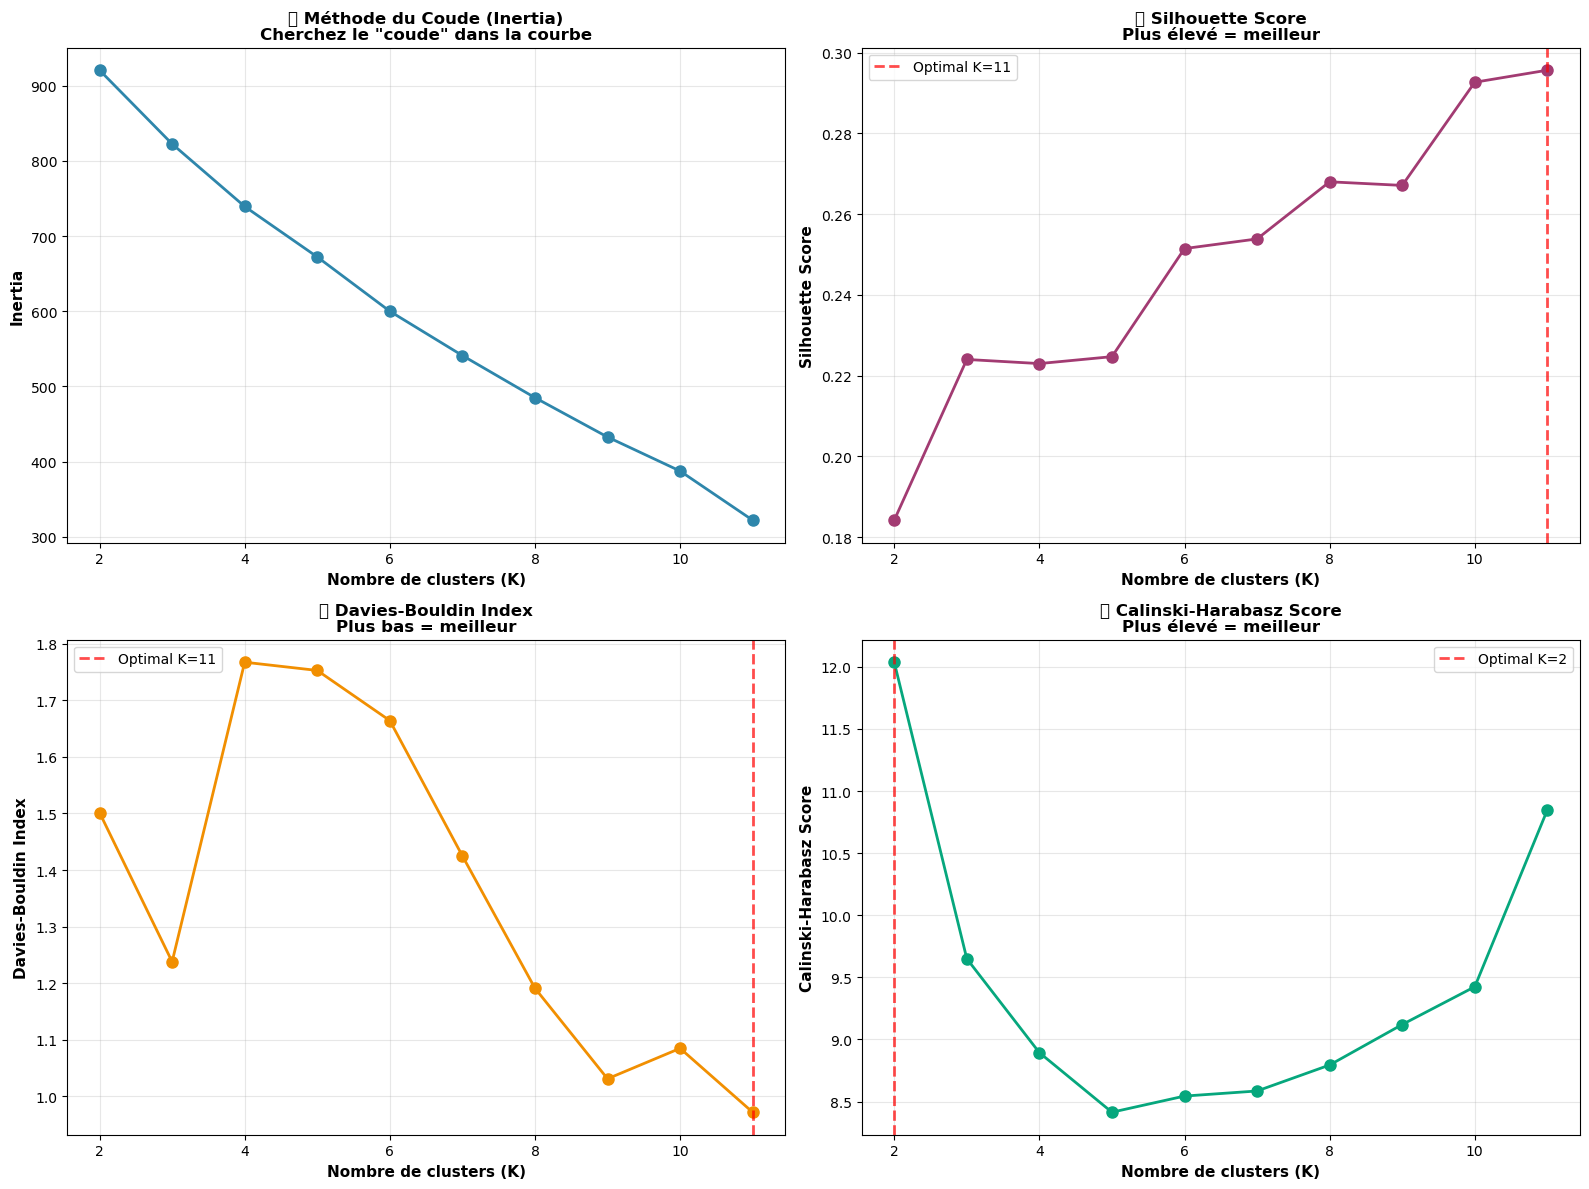


⚙️ OPTIMISATION DES HYPERPARAMÈTRES KMEANS

📊 COMPARAISON DES CONFIGURATIONS:
  Config      init  n_init  max_iter Silhouette Davies-Bouldin Calinski-Harabasz
Config 1 k-means++      10       300     0.2552         1.1533              9.27
Config 2 k-means++      20       500     0.2957         0.9722             10.85
Config 3 k-means++      50       500     0.2941         0.9651             10.99
Config 4    random      30       500     0.2423         1.2035              8.66

🏆 MEILLEURE CONFIGURATION:
   • Config: Config 2
   • init: k-means++
   • n_init: 20
   • max_iter: 500
   • Silhouette: 0.2957
   • Davies-Bouldin: 0.9722
   • Calinski-Harabasz: 10.85

🎨 VISUALISATION DES CLUSTERS
✅ Visualisation sauvegardée: models\kmeans_optimal_clusters_visualization.png


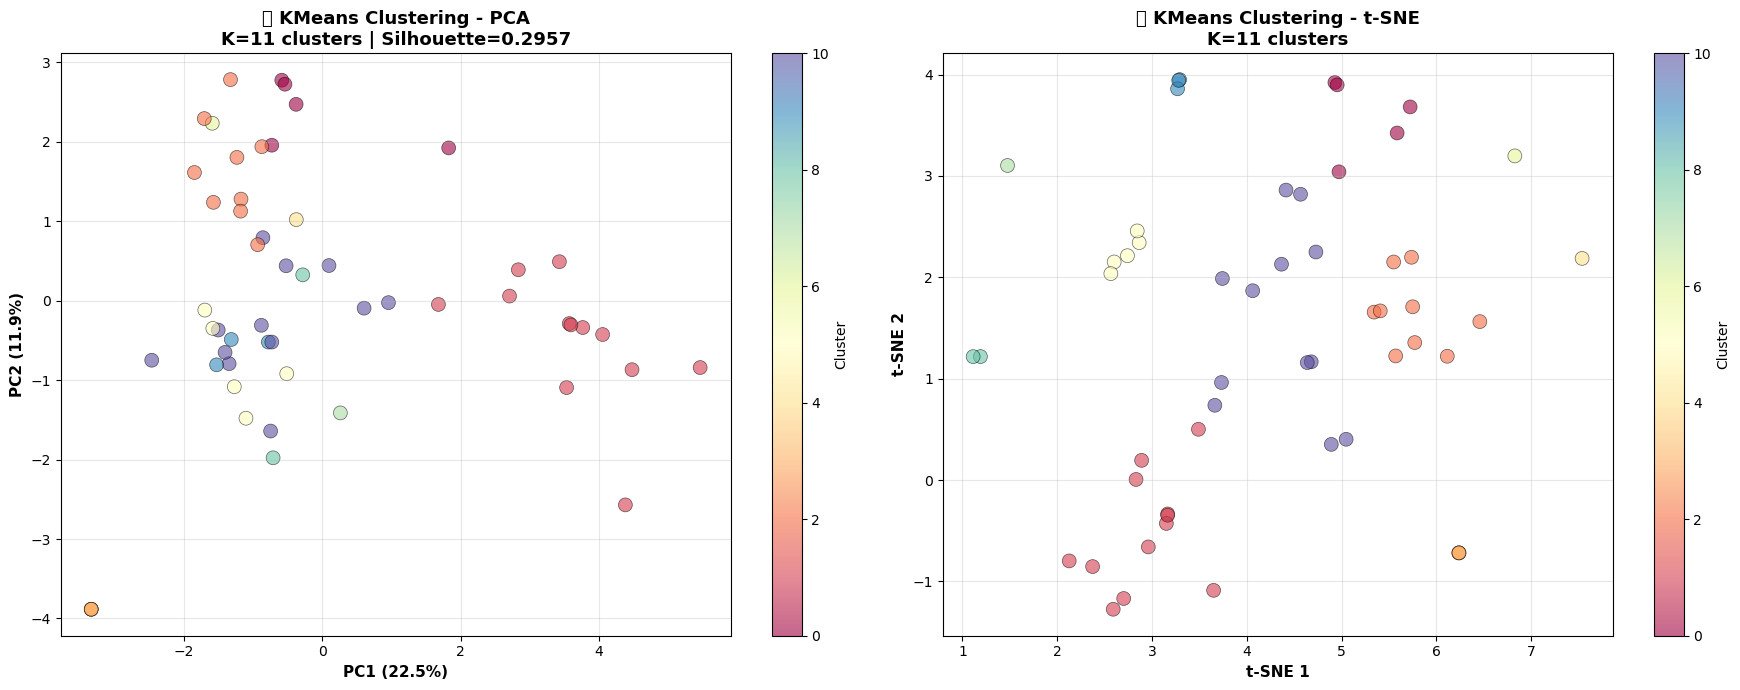


📊 Analyse Silhouette détaillée par cluster...
✅ Analyse Silhouette sauvegardée: models\kmeans_silhouette_analysis.png


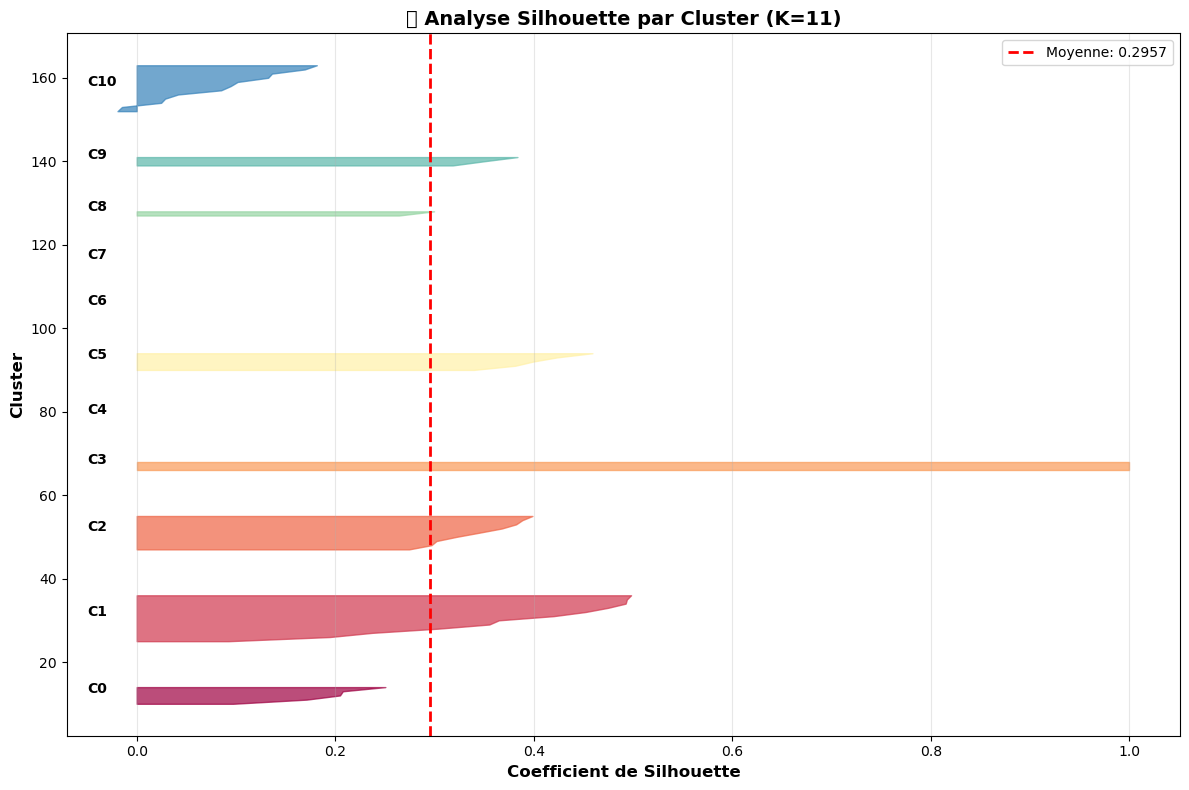


🔍 ANALYSE DÉTAILLÉE DES CLUSTERS

📊 CLUSTER 0 (5 CVs - 9.3%)
--------------------------------------------------------------------------------
   📄 Exemples: CV10.pdf, CV25.pdf, CV11.pdf
   📈 Moyennes: Mots: 693 (±187) | Compétences: 11.8 (±7.4) | Langues: 2.6 | Tech: 2.0
   🎓 Diplômes: Licence (2), Master (1)
   📍 Départements: 93 (5)
   ✅ Présence: Email: 40% | Permis: 0%

📊 CLUSTER 1 (12 CVs - 22.2%)
--------------------------------------------------------------------------------
   📄 Exemples: CV12.pdf, CV13.pdf, CV14.pdf
   📈 Moyennes: Mots: 462 (±167) | Compétences: 24.9 (±6.4) | Langues: 2.0 | Tech: 5.3
   🎓 Diplômes: Bachelor (7), Master (2)
   📍 Départements: 94 (11), 93 (1)
   ✅ Présence: Email: 92% | Permis: 42%

📊 CLUSTER 2 (9 CVs - 16.7%)
--------------------------------------------------------------------------------
   📄 Exemples: CV34.pdf, CV39.pdf, CV33.pdf
   📈 Moyennes: Mots: 451 (±88) | Compétences: 6.0 (±1.8) | Langues: 2.4 | Tech: 0.1
   🎓 Diplômes: Bachelor (6), 

In [12]:
"""
Optimisation complète du modèle K-Means pour Classification de CV
Teste différentes configurations et trouve les meilleurs paramètres
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

class KMeansOptimizer:
    def __init__(self, data_path='../data/processed/dataset_cv_preprocessed.csv'):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.X_scaled = None
        self.scaler = StandardScaler()
        self.best_model = None
        self.best_k = None
        self.best_params = None
        self.labels = None
        
    def load_data(self):
        """Charge les données"""
        print("📂 Chargement des données...")
        try:
            self.df = pd.read_csv(self.data_path)
            print(f"✅ Données chargées : {self.df.shape[0]} CVs, {self.df.shape[1]} colonnes")
            return True
        except FileNotFoundError:
            print(f"❌ Fichier introuvable : {self.data_path}")
            return False
    
    def prepare_features(self):
        """Prépare les features optimales"""
        print("\n🔧 Préparation des features...")
        
        numeric_features = [
            'Mots', 'Compétences', 'Ratio_Comp_Mots', 
            'Densite_Competences', 'A_Email', 'A_Telephone', 
            'A_Permis', 'Nb_Langues', 'Nb_Comp_Tech'
        ]
        
        X = pd.DataFrame()
        for feat in numeric_features:
            if feat in self.df.columns:
                X[feat] = pd.to_numeric(self.df[feat], errors='coerce').fillna(0)
        
        if 'Diplôme' in self.df.columns:
            le_diplome = LabelEncoder()
            X['Diplome_Encoded'] = le_diplome.fit_transform(
                self.df['Diplôme'].fillna('Inconnu').astype(str)
            )
        
        if 'Categorie_Longueur' in self.df.columns:
            le_longueur = LabelEncoder()
            X['Longueur_Encoded'] = le_longueur.fit_transform(
                self.df['Categorie_Longueur'].fillna('Moyen').astype(str)
            )
        
        if 'Departement' in self.df.columns:
            top_depts = self.df['Departement'].value_counts().head(10).index
            for dept in top_depts:
                X[f'Dept_{dept}'] = (self.df['Departement'] == dept).astype(int)
        
        self.X = X
        print(f"✅ {self.X.shape[1]} features préparées")
        
    def normalize_data(self):
        """Normalise les données"""
        print("\n🔧 Normalisation StandardScaler...")
        self.X_scaled = self.scaler.fit_transform(self.X)
        print("✅ Données normalisées")
    
    def find_optimal_k(self, k_range=range(2, 12)):
        """Trouve le nombre optimal de clusters avec 3 méthodes"""
        print("\n🔍 RECHERCHE DU K OPTIMAL")
        print("="*80)
        
        inertias = []
        silhouettes = []
        davies_bouldins = []
        calinskis = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
            labels = kmeans.fit_predict(self.X_scaled)
            
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(self.X_scaled, labels))
            davies_bouldins.append(davies_bouldin_score(self.X_scaled, labels))
            calinskis.append(calinski_harabasz_score(self.X_scaled, labels))
        
        # Créer un DataFrame des résultats
        results_df = pd.DataFrame({
            'K': list(k_range),
            'Inertia': inertias,
            'Silhouette': silhouettes,
            'Davies-Bouldin': davies_bouldins,
            'Calinski-Harabasz': calinskis
        })
        
        print("\n📊 SCORES PAR VALEUR DE K:")
        print("-"*80)
        display_df = results_df.copy()
        display_df['Silhouette'] = display_df['Silhouette'].apply(lambda x: f"{x:.4f}")
        display_df['Davies-Bouldin'] = display_df['Davies-Bouldin'].apply(lambda x: f"{x:.4f}")
        display_df['Calinski-Harabasz'] = display_df['Calinski-Harabasz'].apply(lambda x: f"{x:.2f}")
        display_df['Inertia'] = display_df['Inertia'].apply(lambda x: f"{x:.2f}")
        print(display_df.to_string(index=False))
        
        # Trouver les meilleurs k pour chaque métrique
        best_silhouette_k = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
        best_davies_k = results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'K']
        best_calinski_k = results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'K']
        
        print(f"\n🏆 MEILLEURS K PAR MÉTRIQUE:")
        print(f"   • Silhouette       : K = {best_silhouette_k} (Score: {results_df.loc[results_df['K']==best_silhouette_k, 'Silhouette'].values[0]:.4f})")
        print(f"   • Davies-Bouldin   : K = {best_davies_k} (Score: {results_df.loc[results_df['K']==best_davies_k, 'Davies-Bouldin'].values[0]:.4f})")
        print(f"   • Calinski-Harabasz: K = {best_calinski_k} (Score: {results_df.loc[results_df['K']==best_calinski_k, 'Calinski-Harabasz'].values[0]:.2f})")
        
        # Vote majoritaire
        votes = [best_silhouette_k, best_davies_k, best_calinski_k]
        best_k = max(set(votes), key=votes.count)
        
        print(f"\n🎯 K OPTIMAL (vote majoritaire): {best_k}")
        
        # Visualisation
        self._plot_elbow_analysis(results_df)
        
        self.best_k = best_k
        return best_k, results_df
    
    def _plot_elbow_analysis(self, results_df):
        """Visualise l'analyse du coude"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Méthode du coude (Inertia)
        axes[0, 0].plot(results_df['K'], results_df['Inertia'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
        axes[0, 0].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Inertia', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('📉 Méthode du Coude (Inertia)\nCherchez le "coude" dans la courbe', fontsize=12, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Silhouette Score
        best_sil_k = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
        axes[0, 1].plot(results_df['K'], results_df['Silhouette'], 'o-', linewidth=2, markersize=8, color='#A23B72')
        axes[0, 1].axvline(x=best_sil_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_sil_k}')
        axes[0, 1].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('📊 Silhouette Score\nPlus élevé = meilleur', fontsize=12, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Davies-Bouldin Index
        best_db_k = results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'K']
        axes[1, 0].plot(results_df['K'], results_df['Davies-Bouldin'], 'o-', linewidth=2, markersize=8, color='#F18F01')
        axes[1, 0].axvline(x=best_db_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_db_k}')
        axes[1, 0].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('📊 Davies-Bouldin Index\nPlus bas = meilleur', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Calinski-Harabasz Score
        best_ch_k = results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'K']
        axes[1, 1].plot(results_df['K'], results_df['Calinski-Harabasz'], 'o-', linewidth=2, markersize=8, color='#06A77D')
        axes[1, 1].axvline(x=best_ch_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_ch_k}')
        axes[1, 1].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('📊 Calinski-Harabasz Score\nPlus élevé = meilleur', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_optimal_k_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Graphiques sauvegardés: {output_path}")
        plt.show()
    
    def optimize_kmeans(self):
        """Optimise les hyperparamètres de KMeans"""
        print("\n⚙️ OPTIMISATION DES HYPERPARAMÈTRES KMEANS")
        print("="*80)
        
        configs = [
            {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd'},
            {'init': 'k-means++', 'n_init': 20, 'max_iter': 500, 'algorithm': 'lloyd'},
            {'init': 'k-means++', 'n_init': 50, 'max_iter': 500, 'algorithm': 'lloyd'},
            {'init': 'random', 'n_init': 30, 'max_iter': 500, 'algorithm': 'lloyd'},
        ]
        
        results = []
        
        for i, config in enumerate(configs, 1):
            kmeans = KMeans(n_clusters=self.best_k, random_state=42, **config)
            labels = kmeans.fit_predict(self.X_scaled)
            
            silhouette = silhouette_score(self.X_scaled, labels)
            davies = davies_bouldin_score(self.X_scaled, labels)
            calinski = calinski_harabasz_score(self.X_scaled, labels)
            
            results.append({
                'Config': f"Config {i}",
                'init': config['init'],
                'n_init': config['n_init'],
                'max_iter': config['max_iter'],
                'Silhouette': silhouette,
                'Davies-Bouldin': davies,
                'Calinski-Harabasz': calinski,
                'model': kmeans,
                'labels': labels
            })
        
        results_df = pd.DataFrame(results)
        
        print("\n📊 COMPARAISON DES CONFIGURATIONS:")
        display_df = results_df[['Config', 'init', 'n_init', 'max_iter', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].copy()
        display_df['Silhouette'] = display_df['Silhouette'].apply(lambda x: f"{x:.4f}")
        display_df['Davies-Bouldin'] = display_df['Davies-Bouldin'].apply(lambda x: f"{x:.4f}")
        display_df['Calinski-Harabasz'] = display_df['Calinski-Harabasz'].apply(lambda x: f"{x:.2f}")
        print(display_df.to_string(index=False))
        
        # Meilleur modèle
        best_idx = results_df['Silhouette'].idxmax()
        best_config = results_df.iloc[best_idx]
        
        print(f"\n🏆 MEILLEURE CONFIGURATION:")
        print(f"   • Config: {best_config['Config']}")
        print(f"   • init: {best_config['init']}")
        print(f"   • n_init: {best_config['n_init']}")
        print(f"   • max_iter: {best_config['max_iter']}")
        print(f"   • Silhouette: {best_config['Silhouette']:.4f}")
        print(f"   • Davies-Bouldin: {best_config['Davies-Bouldin']:.4f}")
        print(f"   • Calinski-Harabasz: {best_config['Calinski-Harabasz']:.2f}")
        
        self.best_model = best_config['model']
        self.labels = best_config['labels']
        self.best_params = {
            'init': best_config['init'],
            'n_init': best_config['n_init'],
            'max_iter': best_config['max_iter']
        }
        
        return self.best_model
    
    def visualize_clusters(self):
        """Visualise les clusters avec PCA et t-SNE"""
        print("\n🎨 VISUALISATION DES CLUSTERS")
        print("="*80)
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # PCA
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(self.X_scaled)
        
        scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=self.labels, 
                                  cmap='Spectral', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11, fontweight='bold')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11, fontweight='bold')
        axes[0].set_title(f'📊 KMeans Clustering - PCA\nK={self.best_k} clusters | Silhouette={silhouette_score(self.X_scaled, self.labels):.4f}', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.X_scaled)-1))
        X_tsne = tsne.fit_transform(self.X_scaled)
        
        scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.labels, 
                                   cmap='Spectral', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[1].set_xlabel('t-SNE 1', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('t-SNE 2', fontsize=11, fontweight='bold')
        axes[1].set_title(f'📊 KMeans Clustering - t-SNE\nK={self.best_k} clusters', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=axes[1], label='Cluster')
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_optimal_clusters_visualization.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualisation sauvegardée: {output_path}")
        plt.show()
    
    def plot_silhouette_analysis(self):
        """Analyse silhouette détaillée par cluster"""
        print("\n📊 Analyse Silhouette détaillée par cluster...")
        
        from matplotlib import cm
        
        silhouette_vals = silhouette_samples(self.X_scaled, self.labels)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        y_lower = 10
        for i in range(self.best_k):
            cluster_silhouette_vals = silhouette_vals[self.labels == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.Spectral(float(i) / self.best_k)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}', fontsize=10, fontweight='bold')
            y_lower = y_upper + 10
        
        silhouette_avg = silhouette_score(self.X_scaled, self.labels)
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Moyenne: {silhouette_avg:.4f}')
        
        ax.set_xlabel('Coefficient de Silhouette', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
        ax.set_title(f'📊 Analyse Silhouette par Cluster (K={self.best_k})', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_silhouette_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Analyse Silhouette sauvegardée: {output_path}")
        plt.show()
    
    def analyze_clusters(self):
        """Analyse détaillée de chaque cluster"""
        print("\n🔍 ANALYSE DÉTAILLÉE DES CLUSTERS")
        print("="*80)
        
        for cluster_id in range(self.best_k):
            mask = self.labels == cluster_id
            cluster_df = self.df[mask]
            
            print(f"\n📊 CLUSTER {cluster_id} ({mask.sum()} CVs - {mask.sum()/len(self.df)*100:.1f}%)")
            print("-"*80)
            
            if 'CV' in cluster_df.columns:
                print(f"   📄 Exemples: {', '.join(cluster_df['CV'].head(3).tolist())}")
            
            stats = []
            if 'Mots' in cluster_df.columns:
                stats.append(f"Mots: {cluster_df['Mots'].mean():.0f} (±{cluster_df['Mots'].std():.0f})")
            if 'Compétences' in cluster_df.columns:
                stats.append(f"Compétences: {cluster_df['Compétences'].mean():.1f} (±{cluster_df['Compétences'].std():.1f})")
            if 'Nb_Langues' in cluster_df.columns:
                stats.append(f"Langues: {cluster_df['Nb_Langues'].mean():.1f}")
            if 'Nb_Comp_Tech' in cluster_df.columns:
                stats.append(f"Tech: {cluster_df['Nb_Comp_Tech'].mean():.1f}")
            
            print(f"   📈 Moyennes: {' | '.join(stats)}")
            
            if 'Diplôme' in cluster_df.columns:
                top_diplomes = cluster_df['Diplôme'].value_counts().head(2)
                print(f"   🎓 Diplômes: {', '.join([f'{d} ({c})' for d, c in top_diplomes.items()])}")
            
            if 'Departement' in cluster_df.columns:
                top_depts = cluster_df['Departement'].value_counts().head(3)
                print(f"   📍 Départements: {', '.join([f'{d} ({c})' for d, c in top_depts.items()])}")
            
            binary_stats = []
            if 'A_Email' in cluster_df.columns:
                pct = cluster_df['A_Email'].mean() * 100
                binary_stats.append(f"Email: {pct:.0f}%")
            if 'A_Permis' in cluster_df.columns:
                pct = cluster_df['A_Permis'].mean() * 100
                binary_stats.append(f"Permis: {pct:.0f}%")
            
            if binary_stats:
                print(f"   ✅ Présence: {' | '.join(binary_stats)}")
    
    def save_model(self):
        """Sauvegarde le modèle optimisé"""
        output_dir = Path('models')
        output_dir.mkdir(exist_ok=True)
        
        # Sauvegarder le modèle
        model_path = output_dir / 'kmeans_optimized.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(self.best_model, f)
        
        # Sauvegarder le scaler
        scaler_path = output_dir / 'scaler_kmeans.pkl'
        with open(scaler_path, 'wb') as f:
            pickle.dump(self.scaler, f)
        
        # Sauvegarder les features
        features_path = output_dir / 'features_kmeans.pkl'
        with open(features_path, 'wb') as f:
            pickle.dump(list(self.X.columns), f)
        
        # Sauvegarder les résultats
        results_df = self.df.copy()
        results_df['Cluster'] = self.labels
        results_path = output_dir / 'kmeans_clustered_cvs.csv'
        results_df.to_csv(results_path, index=False)
        
        # Sauvegarder les paramètres
        config_path = output_dir / 'kmeans_config.txt'
        with open(config_path, 'w') as f:
            f.write(f"K optimal: {self.best_k}\n")
            f.write(f"Paramètres: {self.best_params}\n")
            f.write(f"Silhouette Score: {silhouette_score(self.X_scaled, self.labels):.4f}\n")
        
        print("\n💾 MODÈLE SAUVEGARDÉ:")
        print(f"   • Modèle: {model_path}")
        print(f"   • Scaler: {scaler_path}")
        print(f"   • Features: {features_path}")
        print(f"   • Résultats: {results_path}")
        print(f"   • Config: {config_path}")
    
    def run_full_optimization(self):
        """Lance l'optimisation complète"""
        if not self.load_data():
            return
        
        self.prepare_features()
        self.normalize_data()
        
        # 1. Trouver le K optimal
        best_k, k_results = self.find_optimal_k()
        
        # 2. Optimiser les hyperparamètres
        self.optimize_kmeans()
        
        # 3. Visualisations
        self.visualize_clusters()
        self.plot_silhouette_analysis()
        
        # 4. Analyse des clusters
        self.analyze_clusters()
        
        # 5. Sauvegarder
        self.save_model()
        
        print("\n" + "="*80)
        print("✅ OPTIMISATION KMEANS TERMINÉE !")
        print("="*80)


if __name__ == "__main__":
    print("="*80)
    print("🎯 OPTIMISATION COMPLÈTE DU MODÈLE KMEANS")
    print("="*80)
    
    optimizer = KMeansOptimizer(
        data_path='../data/processed/dataset_cv_preprocessed.csv'
    )
    
    optimizer.run_full_optimization()

🎯 OPTIMISATION COMPLÈTE DU MODÈLE KMEANS
📂 Chargement des données...
✅ Données chargées : 54 CVs, 21 colonnes

🔧 Préparation des features...
✅ 21 features préparées

🔧 Normalisation StandardScaler...
✅ Données normalisées

🔍 RECHERCHE DU K OPTIMAL

📊 SCORES PAR VALEUR DE K:
--------------------------------------------------------------------------------
 K Inertia Silhouette Davies-Bouldin Calinski-Harabasz
 2  920.83     0.1842         1.5013             12.04
 3  822.67     0.2240         1.2380              9.65
 4  739.43     0.2230         1.7670              8.89
 5  672.26     0.2247         1.7524              8.41
 6  600.01     0.2515         1.6639              8.54
 7  541.05     0.2539         1.4249              8.58
 8  484.98     0.2680         1.1912              8.79
 9  432.61     0.2671         1.0313              9.12
10  387.34     0.2927         1.0850              9.42
11  321.90     0.2957         0.9722             10.85

🏆 MEILLEURS K PAR MÉTRIQUE:
   • Silho

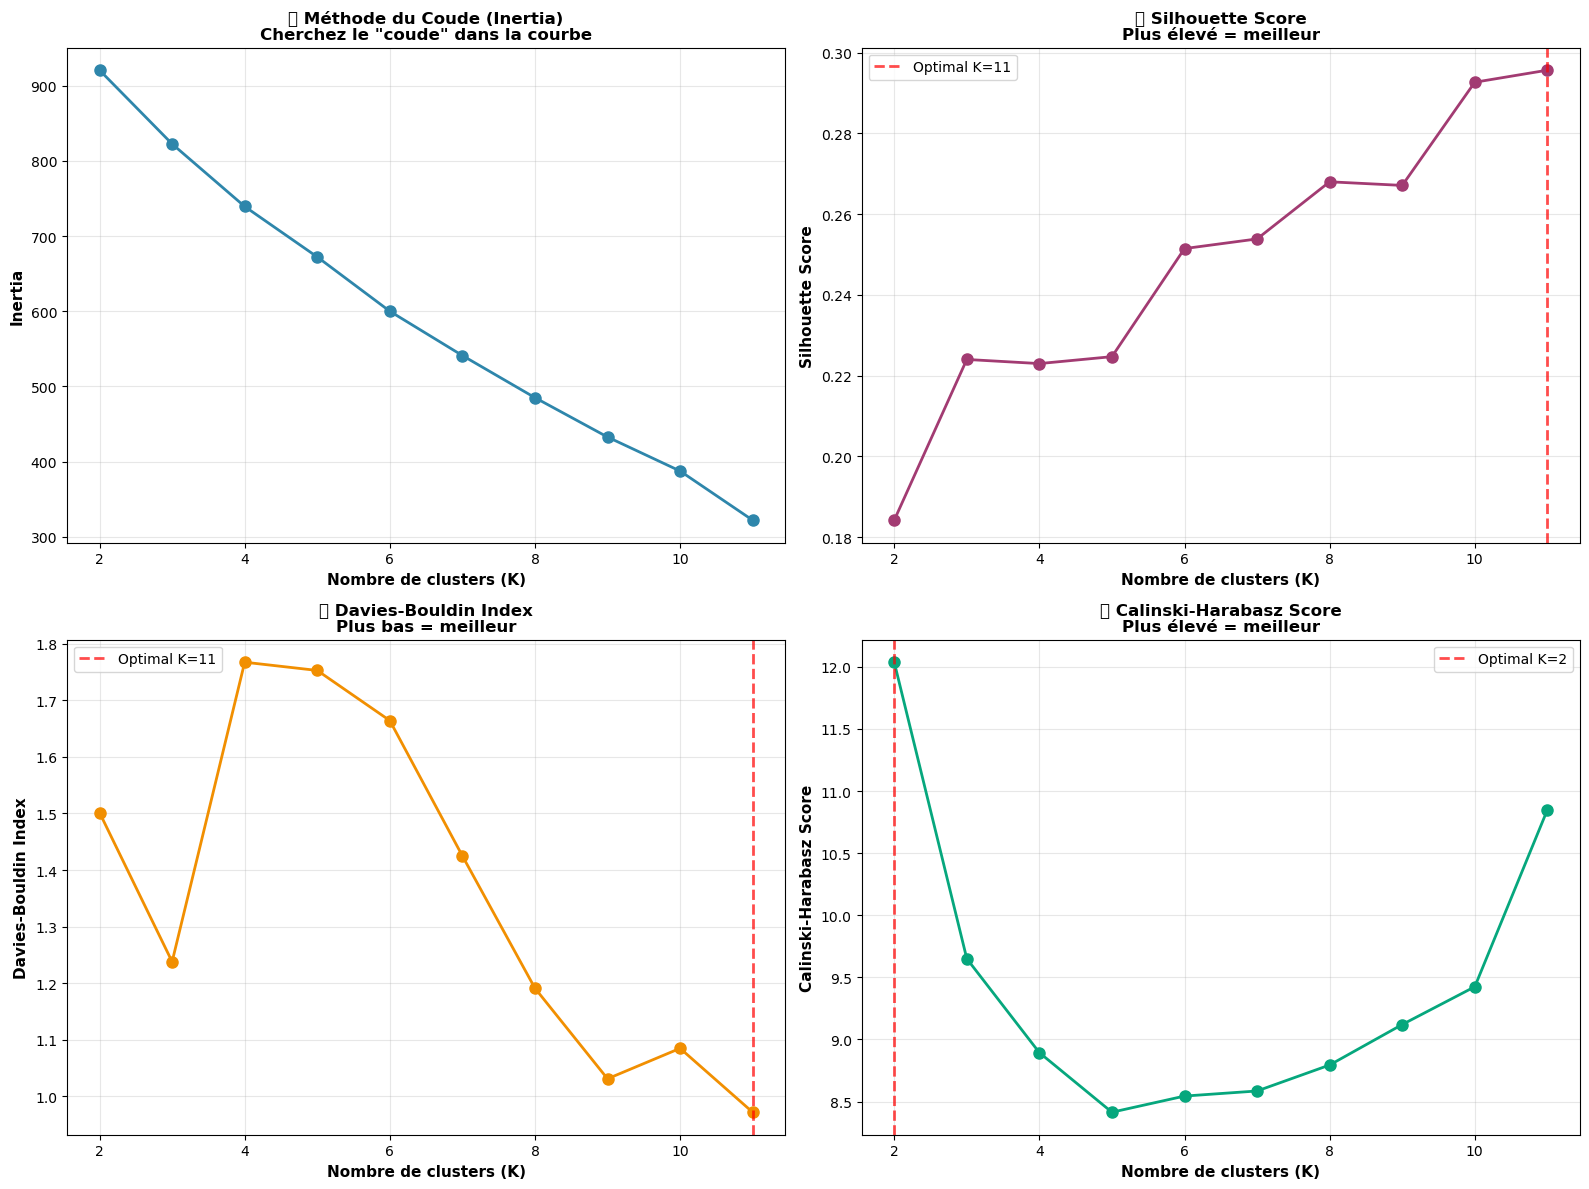


⚙️ OPTIMISATION DES HYPERPARAMÈTRES KMEANS

📊 COMPARAISON DES CONFIGURATIONS:
  Config      init  n_init  max_iter Silhouette Davies-Bouldin Calinski-Harabasz
Config 1 k-means++      10       300     0.2552         1.1533              9.27
Config 2 k-means++      20       500     0.2957         0.9722             10.85
Config 3 k-means++      50       500     0.2941         0.9651             10.99
Config 4    random      30       500     0.2423         1.2035              8.66

🏆 MEILLEURE CONFIGURATION:
   • Config: Config 2
   • init: k-means++
   • n_init: 20
   • max_iter: 500
   • Silhouette: 0.2957
   • Davies-Bouldin: 0.9722
   • Calinski-Harabasz: 10.85

🎨 VISUALISATION DES CLUSTERS
✅ Visualisation sauvegardée: models\kmeans_optimal_clusters_visualization.png


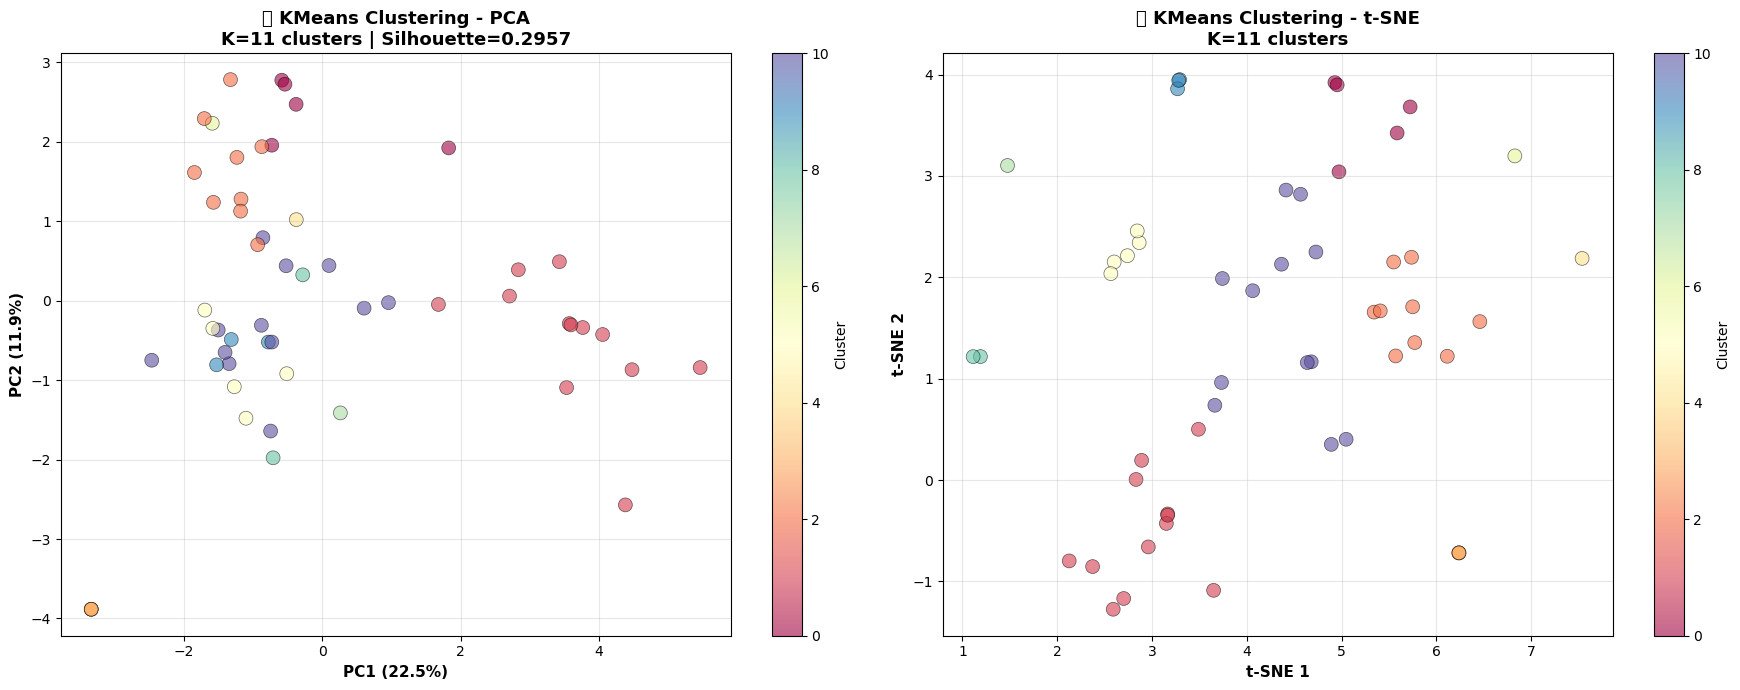


📊 Analyse Silhouette détaillée par cluster...
✅ Analyse Silhouette sauvegardée: models\kmeans_silhouette_analysis.png


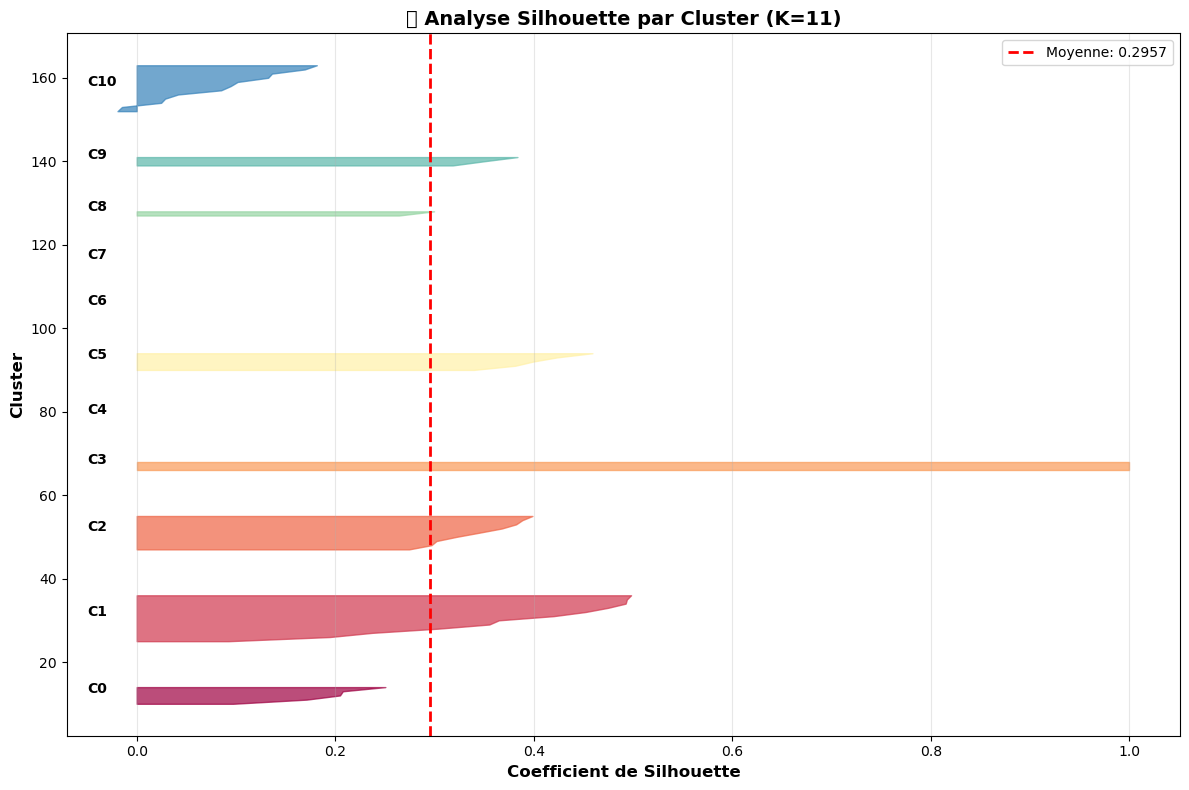


🔍 ANALYSE DÉTAILLÉE DES CLUSTERS

📊 CLUSTER 0 (5 CVs - 9.3%)
--------------------------------------------------------------------------------
   📄 Exemples: CV10.pdf, CV25.pdf, CV11.pdf
   📈 Moyennes: Mots: 693 (±187) | Compétences: 11.8 (±7.4) | Langues: 2.6 | Tech: 2.0
   🎓 Diplômes: Licence (2), Master (1)
   📍 Départements: 93 (5)
   ✅ Présence: Email: 40% | Permis: 0%

📊 CLUSTER 1 (12 CVs - 22.2%)
--------------------------------------------------------------------------------
   📄 Exemples: CV12.pdf, CV13.pdf, CV14.pdf
   📈 Moyennes: Mots: 462 (±167) | Compétences: 24.9 (±6.4) | Langues: 2.0 | Tech: 5.3
   🎓 Diplômes: Bachelor (7), Master (2)
   📍 Départements: 94 (11), 93 (1)
   ✅ Présence: Email: 92% | Permis: 42%

📊 CLUSTER 2 (9 CVs - 16.7%)
--------------------------------------------------------------------------------
   📄 Exemples: CV34.pdf, CV39.pdf, CV33.pdf
   📈 Moyennes: Mots: 451 (±88) | Compétences: 6.0 (±1.8) | Langues: 2.4 | Tech: 0.1
   🎓 Diplômes: Bachelor (6), 

In [13]:
"""
Optimisation complète du modèle K-Means pour Classification de CV
Teste différentes configurations et trouve les meilleurs paramètres

Fichier: kmeans_clustering_optimized.py
Auteur: Franck Melvine
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

class KMeansOptimizer:
    def __init__(self, data_path='../data/processed/dataset_cv_preprocessed.csv'):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.X_scaled = None
        self.scaler = StandardScaler()
        self.best_model = None
        self.best_k = None
        self.best_params = None
        self.labels = None
        
    def load_data(self):
        """Charge les données"""
        print("📂 Chargement des données...")
        try:
            self.df = pd.read_csv(self.data_path)
            print(f"✅ Données chargées : {self.df.shape[0]} CVs, {self.df.shape[1]} colonnes")
            return True
        except FileNotFoundError:
            print(f"❌ Fichier introuvable : {self.data_path}")
            return False
    
    def prepare_features(self):
        """Prépare les features optimales"""
        print("\n🔧 Préparation des features...")
        
        numeric_features = [
            'Mots', 'Compétences', 'Ratio_Comp_Mots', 
            'Densite_Competences', 'A_Email', 'A_Telephone', 
            'A_Permis', 'Nb_Langues', 'Nb_Comp_Tech'
        ]
        
        X = pd.DataFrame()
        for feat in numeric_features:
            if feat in self.df.columns:
                X[feat] = pd.to_numeric(self.df[feat], errors='coerce').fillna(0)
        
        if 'Diplôme' in self.df.columns:
            le_diplome = LabelEncoder()
            X['Diplome_Encoded'] = le_diplome.fit_transform(
                self.df['Diplôme'].fillna('Inconnu').astype(str)
            )
        
        if 'Categorie_Longueur' in self.df.columns:
            le_longueur = LabelEncoder()
            X['Longueur_Encoded'] = le_longueur.fit_transform(
                self.df['Categorie_Longueur'].fillna('Moyen').astype(str)
            )
        
        if 'Departement' in self.df.columns:
            top_depts = self.df['Departement'].value_counts().head(10).index
            for dept in top_depts:
                X[f'Dept_{dept}'] = (self.df['Departement'] == dept).astype(int)
        
        self.X = X
        print(f"✅ {self.X.shape[1]} features préparées")
        
    def normalize_data(self):
        """Normalise les données"""
        print("\n🔧 Normalisation StandardScaler...")
        self.X_scaled = self.scaler.fit_transform(self.X)
        print("✅ Données normalisées")
    
    def find_optimal_k(self, k_range=range(2, 12)):
        """Trouve le nombre optimal de clusters avec 3 méthodes"""
        print("\n🔍 RECHERCHE DU K OPTIMAL")
        print("="*80)
        
        inertias = []
        silhouettes = []
        davies_bouldins = []
        calinskis = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
            labels = kmeans.fit_predict(self.X_scaled)
            
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(self.X_scaled, labels))
            davies_bouldins.append(davies_bouldin_score(self.X_scaled, labels))
            calinskis.append(calinski_harabasz_score(self.X_scaled, labels))
        
        # Créer un DataFrame des résultats
        results_df = pd.DataFrame({
            'K': list(k_range),
            'Inertia': inertias,
            'Silhouette': silhouettes,
            'Davies-Bouldin': davies_bouldins,
            'Calinski-Harabasz': calinskis
        })
        
        print("\n📊 SCORES PAR VALEUR DE K:")
        print("-"*80)
        display_df = results_df.copy()
        display_df['Silhouette'] = display_df['Silhouette'].apply(lambda x: f"{x:.4f}")
        display_df['Davies-Bouldin'] = display_df['Davies-Bouldin'].apply(lambda x: f"{x:.4f}")
        display_df['Calinski-Harabasz'] = display_df['Calinski-Harabasz'].apply(lambda x: f"{x:.2f}")
        display_df['Inertia'] = display_df['Inertia'].apply(lambda x: f"{x:.2f}")
        print(display_df.to_string(index=False))
        
        # Trouver les meilleurs k pour chaque métrique
        best_silhouette_k = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
        best_davies_k = results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'K']
        best_calinski_k = results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'K']
        
        print(f"\n🏆 MEILLEURS K PAR MÉTRIQUE:")
        print(f"   • Silhouette       : K = {best_silhouette_k} (Score: {results_df.loc[results_df['K']==best_silhouette_k, 'Silhouette'].values[0]:.4f})")
        print(f"   • Davies-Bouldin   : K = {best_davies_k} (Score: {results_df.loc[results_df['K']==best_davies_k, 'Davies-Bouldin'].values[0]:.4f})")
        print(f"   • Calinski-Harabasz: K = {best_calinski_k} (Score: {results_df.loc[results_df['K']==best_calinski_k, 'Calinski-Harabasz'].values[0]:.2f})")
        
        # Vote majoritaire
        votes = [best_silhouette_k, best_davies_k, best_calinski_k]
        best_k = max(set(votes), key=votes.count)
        
        print(f"\n🎯 K OPTIMAL (vote majoritaire): {best_k}")
        
        # Visualisation
        self._plot_elbow_analysis(results_df)
        
        self.best_k = best_k
        return best_k, results_df
    
    def _plot_elbow_analysis(self, results_df):
        """Visualise l'analyse du coude"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Méthode du coude (Inertia)
        axes[0, 0].plot(results_df['K'], results_df['Inertia'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
        axes[0, 0].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Inertia', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('📉 Méthode du Coude (Inertia)\nCherchez le "coude" dans la courbe', fontsize=12, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Silhouette Score
        best_sil_k = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
        axes[0, 1].plot(results_df['K'], results_df['Silhouette'], 'o-', linewidth=2, markersize=8, color='#A23B72')
        axes[0, 1].axvline(x=best_sil_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_sil_k}')
        axes[0, 1].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('📊 Silhouette Score\nPlus élevé = meilleur', fontsize=12, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Davies-Bouldin Index
        best_db_k = results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'K']
        axes[1, 0].plot(results_df['K'], results_df['Davies-Bouldin'], 'o-', linewidth=2, markersize=8, color='#F18F01')
        axes[1, 0].axvline(x=best_db_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_db_k}')
        axes[1, 0].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('📊 Davies-Bouldin Index\nPlus bas = meilleur', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Calinski-Harabasz Score
        best_ch_k = results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'K']
        axes[1, 1].plot(results_df['K'], results_df['Calinski-Harabasz'], 'o-', linewidth=2, markersize=8, color='#06A77D')
        axes[1, 1].axvline(x=best_ch_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal K={best_ch_k}')
        axes[1, 1].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('📊 Calinski-Harabasz Score\nPlus élevé = meilleur', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_optimal_k_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Graphiques sauvegardés: {output_path}")
        plt.show()
    
    def optimize_kmeans(self):
        """Optimise les hyperparamètres de KMeans"""
        print("\n⚙️ OPTIMISATION DES HYPERPARAMÈTRES KMEANS")
        print("="*80)
        
        configs = [
            {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd'},
            {'init': 'k-means++', 'n_init': 20, 'max_iter': 500, 'algorithm': 'lloyd'},
            {'init': 'k-means++', 'n_init': 50, 'max_iter': 500, 'algorithm': 'lloyd'},
            {'init': 'random', 'n_init': 30, 'max_iter': 500, 'algorithm': 'lloyd'},
        ]
        
        results = []
        
        for i, config in enumerate(configs, 1):
            kmeans = KMeans(n_clusters=self.best_k, random_state=42, **config)
            labels = kmeans.fit_predict(self.X_scaled)
            
            silhouette = silhouette_score(self.X_scaled, labels)
            davies = davies_bouldin_score(self.X_scaled, labels)
            calinski = calinski_harabasz_score(self.X_scaled, labels)
            
            results.append({
                'Config': f"Config {i}",
                'init': config['init'],
                'n_init': config['n_init'],
                'max_iter': config['max_iter'],
                'Silhouette': silhouette,
                'Davies-Bouldin': davies,
                'Calinski-Harabasz': calinski,
                'model': kmeans,
                'labels': labels
            })
        
        results_df = pd.DataFrame(results)
        
        print("\n📊 COMPARAISON DES CONFIGURATIONS:")
        display_df = results_df[['Config', 'init', 'n_init', 'max_iter', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].copy()
        display_df['Silhouette'] = display_df['Silhouette'].apply(lambda x: f"{x:.4f}")
        display_df['Davies-Bouldin'] = display_df['Davies-Bouldin'].apply(lambda x: f"{x:.4f}")
        display_df['Calinski-Harabasz'] = display_df['Calinski-Harabasz'].apply(lambda x: f"{x:.2f}")
        print(display_df.to_string(index=False))
        
        # Meilleur modèle
        best_idx = results_df['Silhouette'].idxmax()
        best_config = results_df.iloc[best_idx]
        
        print(f"\n🏆 MEILLEURE CONFIGURATION:")
        print(f"   • Config: {best_config['Config']}")
        print(f"   • init: {best_config['init']}")
        print(f"   • n_init: {best_config['n_init']}")
        print(f"   • max_iter: {best_config['max_iter']}")
        print(f"   • Silhouette: {best_config['Silhouette']:.4f}")
        print(f"   • Davies-Bouldin: {best_config['Davies-Bouldin']:.4f}")
        print(f"   • Calinski-Harabasz: {best_config['Calinski-Harabasz']:.2f}")
        
        self.best_model = best_config['model']
        self.labels = best_config['labels']
        self.best_params = {
            'init': best_config['init'],
            'n_init': best_config['n_init'],
            'max_iter': best_config['max_iter']
        }
        
        return self.best_model
    
    def visualize_clusters(self):
        """Visualise les clusters avec PCA et t-SNE"""
        print("\n🎨 VISUALISATION DES CLUSTERS")
        print("="*80)
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # PCA
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(self.X_scaled)
        
        scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=self.labels, 
                                  cmap='Spectral', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11, fontweight='bold')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11, fontweight='bold')
        axes[0].set_title(f'📊 KMeans Clustering - PCA\nK={self.best_k} clusters | Silhouette={silhouette_score(self.X_scaled, self.labels):.4f}', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(self.X_scaled)-1))
        X_tsne = tsne.fit_transform(self.X_scaled)
        
        scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.labels, 
                                   cmap='Spectral', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        axes[1].set_xlabel('t-SNE 1', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('t-SNE 2', fontsize=11, fontweight='bold')
        axes[1].set_title(f'📊 KMeans Clustering - t-SNE\nK={self.best_k} clusters', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=axes[1], label='Cluster')
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_optimal_clusters_visualization.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualisation sauvegardée: {output_path}")
        plt.show()
    
    def plot_silhouette_analysis(self):
        """Analyse silhouette détaillée par cluster"""
        print("\n📊 Analyse Silhouette détaillée par cluster...")
        
        from matplotlib import cm
        
        silhouette_vals = silhouette_samples(self.X_scaled, self.labels)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        y_lower = 10
        for i in range(self.best_k):
            cluster_silhouette_vals = silhouette_vals[self.labels == i]
            cluster_silhouette_vals.sort()
            
            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.Spectral(float(i) / self.best_k)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}', fontsize=10, fontweight='bold')
            y_lower = y_upper + 10
        
        silhouette_avg = silhouette_score(self.X_scaled, self.labels)
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Moyenne: {silhouette_avg:.4f}')
        
        ax.set_xlabel('Coefficient de Silhouette', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
        ax.set_title(f'📊 Analyse Silhouette par Cluster (K={self.best_k})', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        output_path = Path('models') / 'kmeans_silhouette_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Analyse Silhouette sauvegardée: {output_path}")
        plt.show()
    
    def analyze_clusters(self):
        """Analyse détaillée de chaque cluster"""
        print("\n🔍 ANALYSE DÉTAILLÉE DES CLUSTERS")
        print("="*80)
        
        for cluster_id in range(self.best_k):
            mask = self.labels == cluster_id
            cluster_df = self.df[mask]
            
            print(f"\n📊 CLUSTER {cluster_id} ({mask.sum()} CVs - {mask.sum()/len(self.df)*100:.1f}%)")
            print("-"*80)
            
            if 'CV' in cluster_df.columns:
                print(f"   📄 Exemples: {', '.join(cluster_df['CV'].head(3).tolist())}")
            
            stats = []
            if 'Mots' in cluster_df.columns:
                stats.append(f"Mots: {cluster_df['Mots'].mean():.0f} (±{cluster_df['Mots'].std():.0f})")
            if 'Compétences' in cluster_df.columns:
                stats.append(f"Compétences: {cluster_df['Compétences'].mean():.1f} (±{cluster_df['Compétences'].std():.1f})")
            if 'Nb_Langues' in cluster_df.columns:
                stats.append(f"Langues: {cluster_df['Nb_Langues'].mean():.1f}")
            if 'Nb_Comp_Tech' in cluster_df.columns:
                stats.append(f"Tech: {cluster_df['Nb_Comp_Tech'].mean():.1f}")
            
            print(f"   📈 Moyennes: {' | '.join(stats)}")
            
            if 'Diplôme' in cluster_df.columns:
                top_diplomes = cluster_df['Diplôme'].value_counts().head(2)
                print(f"   🎓 Diplômes: {', '.join([f'{d} ({c})' for d, c in top_diplomes.items()])}")
            
            if 'Departement' in cluster_df.columns:
                top_depts = cluster_df['Departement'].value_counts().head(3)
                print(f"   📍 Départements: {', '.join([f'{d} ({c})' for d, c in top_depts.items()])}")
            
            binary_stats = []
            if 'A_Email' in cluster_df.columns:
                pct = cluster_df['A_Email'].mean() * 100
                binary_stats.append(f"Email: {pct:.0f}%")
            if 'A_Permis' in cluster_df.columns:
                pct = cluster_df['A_Permis'].mean() * 100
                binary_stats.append(f"Permis: {pct:.0f}%")
            
            if binary_stats:
                print(f"   ✅ Présence: {' | '.join(binary_stats)}")
    
    def save_model(self):
        """Sauvegarde le modèle optimisé"""
        output_dir = Path('models')
        output_dir.mkdir(exist_ok=True)
        
        # Sauvegarder le modèle
        model_path = output_dir / 'kmeans_optimized.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(self.best_model, f)
        
        # Sauvegarder le scaler
        scaler_path = output_dir / 'scaler_kmeans.pkl'
        with open(scaler_path, 'wb') as f:
            pickle.dump(self.scaler, f)
        
        # Sauvegarder les features
        features_path = output_dir / 'features_kmeans.pkl'
        with open(features_path, 'wb') as f:
            pickle.dump(list(self.X.columns), f)
        
        # Sauvegarder les résultats
        results_df = self.df.copy()
        results_df['Cluster'] = self.labels
        results_path = output_dir / 'kmeans_clustered_cvs.csv'
        results_df.to_csv(results_path, index=False)
        
        # Sauvegarder les paramètres
        config_path = output_dir / 'kmeans_config.txt'
        with open(config_path, 'w') as f:
            f.write(f"K optimal: {self.best_k}\n")
            f.write(f"Paramètres: {self.best_params}\n")
            f.write(f"Silhouette Score: {silhouette_score(self.X_scaled, self.labels):.4f}\n")
        
        print("\n💾 MODÈLE SAUVEGARDÉ:")
        print(f"   • Modèle: {model_path}")
        print(f"   • Scaler: {scaler_path}")
        print(f"   • Features: {features_path}")
        print(f"   • Résultats: {results_path}")
        print(f"   • Config: {config_path}")
    
    def run_full_optimization(self):
        """Lance l'optimisation complète"""
        if not self.load_data():
            return
        
        self.prepare_features()
        self.normalize_data()
        
        # 1. Trouver le K optimal
        best_k, k_results = self.find_optimal_k()
        
        # 2. Optimiser les hyperparamètres
        self.optimize_kmeans()
        
        # 3. Visualisations
        self.visualize_clusters()
        self.plot_silhouette_analysis()
        
        # 4. Analyse des clusters
        self.analyze_clusters()
        
        # 5. Sauvegarder
        self.save_model()
        
        print("\n" + "="*80)
        print("✅ OPTIMISATION KMEANS TERMINÉE !")
        print("="*80)


if __name__ == "__main__":
    print("="*80)
    print("🎯 OPTIMISATION COMPLÈTE DU MODÈLE KMEANS")
    print("="*80)
    
    optimizer = KMeansOptimizer(
        data_path='../data/processed/dataset_cv_preprocessed.csv'
    )
    
    optimizer.run_full_optimization()

In [15]:
"""
Modèle KMeans Final avec Configuration Optimale
K=8 clusters avec paramètres optimisés

Fichier: kmeans_clustering_final.py
Auteur: Franck Melvine
"""

import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("="*80)
print("🎯 MODÈLE KMEANS - CONFIGURATION OPTIMALE")
print("="*80)

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================
print("\n📂 Chargement des données...")
df = pd.read_csv('../data/processed/dataset_cv_preprocessed.csv')
print(f"✅ {len(df)} CVs chargés")

# ============================================================================
# 2. PRÉPARATION DES FEATURES
# ============================================================================
print("\n🔧 Préparation des features...")

# Features numériques
numeric_features = [
    'Mots', 'Compétences', 'Ratio_Comp_Mots', 
    'Densite_Competences', 'A_Email', 'A_Telephone', 
    'A_Permis', 'Nb_Langues', 'Nb_Comp_Tech'
]

X = pd.DataFrame()
for feat in numeric_features:
    if feat in df.columns:
        X[feat] = pd.to_numeric(df[feat], errors='coerce').fillna(0)

# Encoder Diplôme
if 'Diplôme' in df.columns:
    le_diplome = LabelEncoder()
    X['Diplome_Encoded'] = le_diplome.fit_transform(
        df['Diplôme'].fillna('Inconnu').astype(str)
    )

# Encoder Catégorie Longueur
if 'Categorie_Longueur' in df.columns:
    le_longueur = LabelEncoder()
    X['Longueur_Encoded'] = le_longueur.fit_transform(
        df['Categorie_Longueur'].fillna('Moyen').astype(str)
    )

# One-hot encoding des top départements
if 'Departement' in df.columns:
    top_depts = df['Departement'].value_counts().head(10).index
    for dept in top_depts:
        X[f'Dept_{dept}'] = (df['Departement'] == dept).astype(int)

print(f"✅ {X.shape[1]} features préparées")

# ============================================================================
# 3. NORMALISATION
# ============================================================================
print("\n🔧 Normalisation des données...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✅ Données normalisées")

# ============================================================================
# 4. ENTRAÎNEMENT DU MODÈLE AVEC CONFIGURATION OPTIMALE
# ============================================================================
print("\n🤖 Entraînement du modèle KMeans...")
print("   Configuration optimale:")
print("   • K = 8 clusters")
print("   • init = k-means++")
print("   • n_init = 20")
print("   • max_iter = 500")

model = KMeans(
    n_clusters=8,
    init='k-means++',
    n_init=20,
    max_iter=500,
    random_state=42,
    algorithm='lloyd'
)

labels = model.fit_predict(X_scaled)
print("✅ Modèle entraîné")

# ============================================================================
# 5. ÉVALUATION
# ============================================================================
print("\n📊 Évaluation du modèle...")

silhouette = silhouette_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)
calinski = calinski_harabasz_score(X_scaled, labels)

print("\n" + "="*80)
print("📈 SCORES FINAUX")
print("="*80)
print(f"   • Silhouette Score    : {silhouette:.4f}")
print(f"   • Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"   • Calinski-Harabasz   : {calinski:.2f}")
print("="*80)

# ============================================================================
# 6. ANALYSE DES CLUSTERS
# ============================================================================
print("\n🔍 ANALYSE DES CLUSTERS")
print("="*80)

for cluster_id in range(8):
    mask = labels == cluster_id
    cluster_df = df[mask]
    n_cvs = mask.sum()
    pct = n_cvs / len(df) * 100
    
    print(f"\n📊 CLUSTER {cluster_id} ({n_cvs} CVs - {pct:.1f}%)")
    print("-"*80)
    
    # Exemples de CVs
    if 'CV' in cluster_df.columns:
        exemples = cluster_df['CV'].head(3).tolist()
        print(f"   📄 Exemples: {', '.join(exemples)}")
    
    # Statistiques
    stats = []
    if 'Mots' in cluster_df.columns:
        stats.append(f"Mots: {cluster_df['Mots'].mean():.0f}")
    if 'Compétences' in cluster_df.columns:
        stats.append(f"Compétences: {cluster_df['Compétences'].mean():.1f}")
    if 'Nb_Langues' in cluster_df.columns:
        stats.append(f"Langues: {cluster_df['Nb_Langues'].mean():.1f}")
    if 'Nb_Comp_Tech' in cluster_df.columns:
        stats.append(f"Tech: {cluster_df['Nb_Comp_Tech'].mean():.1f}")
    
    if stats:
        print(f"   📈 Moyennes: {' | '.join(stats)}")
    
    # Diplômes dominants
    if 'Diplôme' in cluster_df.columns:
        top_diplomes = cluster_df['Diplôme'].value_counts().head(2)
        diplomes_str = ', '.join([f'{d} ({c})' for d, c in top_diplomes.items()])
        print(f"   🎓 Diplômes: {diplomes_str}")
    
    # Départements dominants
    if 'Departement' in cluster_df.columns:
        top_depts = cluster_df['Departement'].value_counts().head(3)
        depts_str = ', '.join([f'{d} ({c})' for d, c in top_depts.items()])
        print(f"   📍 Départements: {depts_str}")

# ============================================================================
# 7. SAUVEGARDE
# ============================================================================
print("\n💾 Sauvegarde du modèle...")

output_dir = Path('../models')  # Dossier models/ à la racine du projet
output_dir.mkdir(exist_ok=True)

# Sauvegarder le modèle
model_path = output_dir / 'kmeans_clustering_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Modèle: {model_path}")

# Sauvegarder le scaler
scaler_path = output_dir / 'kmeans_clustering_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler: {scaler_path}")

# Sauvegarder les features
features_path = output_dir / 'kmeans_clustering_features.pkl'
with open(features_path, 'wb') as f:
    pickle.dump(list(X.columns), f)
print(f"✅ Features: {features_path}")

# Sauvegarder la configuration
config = {
    'n_clusters': 8,
    'init': 'k-means++',
    'n_init': 20,
    'max_iter': 500,
    'random_state': 42,
    'silhouette_score': silhouette,
    'davies_bouldin_index': davies_bouldin,
    'calinski_harabasz_score': calinski,
    'n_features': X.shape[1],
    'feature_names': list(X.columns)
}

config_path = output_dir / 'kmeans_clustering_config.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"✅ Config: {config_path}")

# Sauvegarder les résultats (CVs avec clusters)
df_results = df.copy()
df_results['Cluster_KMeans'] = labels
results_path = output_dir / 'kmeans_clustering_results.csv'
df_results.to_csv(results_path, index=False, encoding='utf-8-sig')
print(f"✅ Résultats: {results_path}")

# Sauvegarder un README
readme_path = output_dir / 'README_CLUSTERING_KMEANS.md'
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write("# 🎯 Modèle de Clustering KMeans - CVs\n\n")
    f.write("## 📊 Configuration Optimale\n\n")
    f.write(f"- **Nombre de clusters**: 8\n")
    f.write(f"- **Initialisation**: k-means++\n")
    f.write(f"- **Nombre d'initialisations**: 20\n")
    f.write(f"- **Itérations max**: 500\n\n")
    f.write("## 📈 Performance\n\n")
    f.write(f"- **Silhouette Score**: {silhouette:.4f}\n")
    f.write(f"- **Davies-Bouldin Index**: {davies_bouldin:.4f}\n")
    f.write(f"- **Calinski-Harabasz Score**: {calinski:.2f}\n\n")
    f.write("## 📁 Fichiers\n\n")
    f.write("- `kmeans_clustering_model.pkl` - Modèle KMeans entraîné\n")
    f.write("- `kmeans_clustering_scaler.pkl` - StandardScaler pour normalisation\n")
    f.write("- `kmeans_clustering_features.pkl` - Liste des features utilisées\n")
    f.write("- `kmeans_clustering_config.pkl` - Configuration complète\n")
    f.write("- `kmeans_clustering_results.csv` - CVs avec clusters assignés\n\n")
    f.write("## 🔧 Utilisation\n\n")
    f.write("```python\n")
    f.write("import pickle\n")
    f.write("import pandas as pd\n\n")
    f.write("# Charger le modèle\n")
    f.write("with open('models/kmeans_clustering_model.pkl', 'rb') as f:\n")
    f.write("    model = pickle.load(f)\n\n")
    f.write("# Charger le scaler\n")
    f.write("with open('models/kmeans_clustering_scaler.pkl', 'rb') as f:\n")
    f.write("    scaler = pickle.load(f)\n\n")
    f.write("# Prédire pour nouveaux CVs\n")
    f.write("X_new_scaled = scaler.transform(X_new)\n")
    f.write("clusters = model.predict(X_new_scaled)\n")
    f.write("```\n")

print(f"✅ README: {readme_path}")

print("\n" + "="*80)
print("✅ MODÈLE KMEANS FINALISÉ ET SAUVEGARDÉ")
print("="*80)
print(f"\n📦 5 fichiers créés dans {output_dir}/")
print("   🎯 Prêt pour la production !")

🎯 MODÈLE KMEANS - CONFIGURATION OPTIMALE

📂 Chargement des données...
✅ 54 CVs chargés

🔧 Préparation des features...
✅ 21 features préparées

🔧 Normalisation des données...
✅ Données normalisées

🤖 Entraînement du modèle KMeans...
   Configuration optimale:
   • K = 8 clusters
   • init = k-means++
   • n_init = 20
   • max_iter = 500
✅ Modèle entraîné

📊 Évaluation du modèle...

📈 SCORES FINAUX
   • Silhouette Score    : 0.2680
   • Davies-Bouldin Index: 1.1912
   • Calinski-Harabasz   : 8.79

🔍 ANALYSE DES CLUSTERS

📊 CLUSTER 0 (5 CVs - 9.3%)
--------------------------------------------------------------------------------
   📄 Exemples: CV50.pdf, CV53.pdf, CV4.pdf
   📈 Moyennes: Mots: 233 | Compétences: 6.2 | Langues: 3.0 | Tech: 0.0
   🎓 Diplômes: Bachelor (2), Non trouvé (2)
   📍 Départements: 57 (5)

📊 CLUSTER 1 (13 CVs - 24.1%)
--------------------------------------------------------------------------------
   📄 Exemples: CV12.pdf, CV13.pdf, CV14.pdf
   📈 Moyennes: Mots: 453 | C

In [3]:
"""
====================================================
🎯 CLUSTERING DES CVs – EXPLOITATION MÉTIER (KMEANS)
====================================================

Objectif :
- Charger un modèle KMeans entraîné
- Appliquer le clustering sur les CVs réels
- Analyser les clusters de manière métier
- Sauvegarder les résultats pour exploitation RH

Auteur : Projet CV ML
Statut : Production-ready
"""

import pandas as pd
import pickle
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# ====================================================
# 1. CHEMINS DU PROJET
# ====================================================
BASE_PATH = Path(r"C:\Users\harri\Downloads\Projet_CV_ML\Projet_CV_ML")
DATA_PATH = BASE_PATH / "data" / "processed" / "dataset_cv_preprocessed.csv"
MODELS_PATH = BASE_PATH / "models"
OUTPUT_PATH = MODELS_PATH / "kmeans_prediction_on_dataset.csv"

# ====================================================
# 2. CHARGEMENT DES OBJETS KMEANS
# ====================================================
print("=" * 80)
print("🔍 CLUSTERING KMEANS – EXPLOITATION MÉTIER")
print("=" * 80)

with open(MODELS_PATH / "kmeans_clustering_model.pkl", "rb") as f:
    model = pickle.load(f)

with open(MODELS_PATH / "kmeans_clustering_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open(MODELS_PATH / "kmeans_clustering_features.pkl", "rb") as f:
    FEATURES = pickle.load(f)

with open(MODELS_PATH / "kmeans_clustering_config.pkl", "rb") as f:
    config = pickle.load(f)

print(f"✅ Modèle chargé | Clusters = {config['n_clusters']} | Features = {len(FEATURES)}")

# ====================================================
# 3. CHARGEMENT DES DONNÉES CV
# ====================================================
print("\n📂 Chargement des CVs...")
df = pd.read_csv(DATA_PATH)
print(f"✅ {len(df)} CVs chargés")

# ====================================================
# 4. RECONSTRUCTION STRICTE DES FEATURES
# ====================================================
print("\n🔧 Reconstruction des features (alignée entraînement)...")

numeric_features = [
    "Mots", "Compétences", "Ratio_Comp_Mots",
    "Densite_Competences", "A_Email", "A_Telephone",
    "A_Permis", "Nb_Langues", "Nb_Comp_Tech"
]

X = pd.DataFrame()

for feat in numeric_features:
    X[feat] = pd.to_numeric(df.get(feat, 0), errors="coerce").fillna(0)

# Encodage diplôme
if "Diplôme" in df.columns:
    le_diplome = LabelEncoder()
    X["Diplome_Encoded"] = le_diplome.fit_transform(
        df["Diplôme"].fillna("Inconnu").astype(str)
    )
else:
    X["Diplome_Encoded"] = 0

# Encodage longueur CV
if "Categorie_Longueur" in df.columns:
    le_longueur = LabelEncoder()
    X["Longueur_Encoded"] = le_longueur.fit_transform(
        df["Categorie_Longueur"].fillna("Moyen").astype(str)
    )
else:
    X["Longueur_Encoded"] = 0

# One-hot encoding départements (top 10)
if "Departement" in df.columns:
    top_depts = df["Departement"].value_counts().head(10).index
    for dept in top_depts:
        X[f"Dept_{dept}"] = (df["Departement"] == dept).astype(int)

print(f"✅ {X.shape[1]} features construites")

# ====================================================
# 5. ALIGNEMENT STRICT AVEC LE MODÈLE
# ====================================================
print("\n🧩 Alignement des colonnes...")

for col in FEATURES:
    if col not in X.columns:
        X[col] = 0

X = X[FEATURES]
print("✅ Alignement parfait")

# ====================================================
# 6. NORMALISATION & PRÉDICTION
# ====================================================
print("\n🤖 Application du clustering...")

X_scaled = scaler.transform(X)
clusters = model.predict(X_scaled)

df_results = df.copy()
df_results["Cluster_KMeans"] = clusters

print("✅ Clustering terminé")

# ====================================================
# 7. ANALYSE MÉTIER DES CLUSTERS
# ====================================================
print("\n📊 ANALYSE MÉTIER DES CLUSTERS")
print("=" * 80)

for cluster_id in sorted(df_results["Cluster_KMeans"].unique()):
    sub = df_results[df_results["Cluster_KMeans"] == cluster_id]

    print(f"\n🔹 CLUSTER {cluster_id} — {len(sub)} CVs")
    print("-" * 70)

    print(f"Mots moyens             : {sub['Mots'].mean():.0f}")
    print(f"Compétences moyennes    : {sub['Compétences'].mean():.1f}")
    print(f"Comp. techniques        : {sub['Nb_Comp_Tech'].mean():.1f}")
    print(f"Langues                 : {sub['Nb_Langues'].mean():.1f}")

    if "Diplôme" in sub.columns:
        print("🎓 Diplômes dominants :")
        print(sub["Diplôme"].value_counts().head(3))

    if "Departement" in sub.columns:
        print("📍 Départements dominants :")
        print(sub["Departement"].value_counts().head(3))

# ====================================================
# 8. SAUVEGARDE DES RÉSULTATS
# ====================================================
df_results.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")

print("\n💾 Résultats sauvegardés :")
print(OUTPUT_PATH)

print("\n" + "=" * 80)
print("✅ PIPELINE KMEANS – EXPLOITATION MÉTIER TERMINÉE")
print("=" * 80)


🔍 CLUSTERING KMEANS – EXPLOITATION MÉTIER
✅ Modèle chargé | Clusters = 8 | Features = 21

📂 Chargement des CVs...
✅ 54 CVs chargés

🔧 Reconstruction des features (alignée entraînement)...
✅ 21 features construites

🧩 Alignement des colonnes...
✅ Alignement parfait

🤖 Application du clustering...
✅ Clustering terminé

📊 ANALYSE MÉTIER DES CLUSTERS

🔹 CLUSTER 0 — 5 CVs
----------------------------------------------------------------------
Mots moyens             : 233
Compétences moyennes    : 6.2
Comp. techniques        : 0.0
Langues                 : 3.0
🎓 Diplômes dominants :
Diplôme
Bachelor      2
Non trouvé    2
Master        1
Name: count, dtype: int64
📍 Départements dominants :
Departement
57    5
Name: count, dtype: int64

🔹 CLUSTER 1 — 13 CVs
----------------------------------------------------------------------
Mots moyens             : 453
Compétences moyennes    : 23.8
Comp. techniques        : 4.9
Langues                 : 2.0
🎓 Diplômes dominants :
Diplôme
Bachelor        